#  Basic Python ML end-to-end Template. 

This notebook is a basic framework written with Python 3.9 and various library imports for the purposes of providing a basic data analytic end-to-end template.
The objective in this iteration is to load a structured dataset with numerical and categorical attributes, perform exploratory analysis with some limited feature engineering, prepare the data for an ML algorithm, apply and evaluate ML pipeline to data set. 

This project takes a Kaggle dataset of aggregated craigslist rental listings (updated 2020). The goal in this first iteration is to walk through some data exploration and discovery steps to build a model for rental prices using this data. So, in ML this is a supervised prediction problem. We want to be able to predict the median rental price. We will create some metrics to add as features, so it is a good dataset for our purposes since we have to consider and implement several approaches for shaping our feature space.

We will use the Root Mean Square Error as our performance measure for several regression methods. 

Nearly all of the code can be modified to make cleaner or more efficient. Since this is a starter template, all of the code is not required to reach the state of a tuned model, but instead is included for consideration of usage purposes. There exists an innumerable number of ways to do this, and future iterations will expound on some of those approaches and build upon this framework. 
# The following list of dependencies is generated via 'pip' for the local virtual environment dependencies:
*Not all libraries are necessary for this first iteration

anyio==3.4.0
argon2-cffi==21.1.0
attrs==21.2.0
Babel==2.9.1
backcall==0.2.0
bleach==4.1.0
certifi==2021.10.8
cffi==1.15.0
charset-normalizer==2.0.8
click==8.0.3
click-plugins==1.1.1
cligj==0.7.2
colorama==0.4.4
cycler==0.10.0
debugpy==1.5.1
decorator==5.1.0
defusedxml==0.7.1
easy-ht==0.0.1
eli5==0.11.0
entrypoints==0.3
graphviz==0.19
haversine==2.5.1
idna==3.3
ipykernel==6.5.1
ipython==7.29.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.1
Jinja2==3.0.3
joblib==1.0.1
json5==0.9.6
jsonschema==4.2.1
jupyter-client==7.1.0
jupyter-core==4.9.1
jupyter-server==1.12.1
jupyterlab==3.2.4
jupyterlab-pygments==0.1.2
jupyterlab-server==2.8.2
jupyterlab-widgets==1.0.2
kaggle==1.5.12
kaleido==0.2.1
kiwisolver==1.3.1
MarkupSafe==2.0.1
matplotlib==3.4.2
matplotlib-inline==0.1.3
mistune==0.8.4
munch==2.5.0
nbclassic==0.3.4
nbclient==0.5.9
nbconvert==6.3.0
nbformat==5.1.3
nest-asyncio==1.5.1
notebook==6.4.6
numpy==1.21.0
packaging==21.3
pandas==1.3.0
pandocfilters==1.5.0
parso==0.8.2
patsy==0.5.2
pickleshare==0.7.5
Pillow==8.3.0
plotly==5.4.0
prometheus-client==0.12.0
prompt-toolkit==3.0.22
pycparser==2.21
Pygments==2.10.0
pyparsing==2.4.7
pyproj==3.3.0
pyrsistent==0.18.0
python-dateutil==2.8.1
python-slugify==5.0.2
pytz==2021.1
pywin32==302
pywinpty==1.1.6
pyzmq==22.3.0
requests==2.26.0
scikit-learn==0.24.2
scipy==1.7.0
seaborn==0.11.1
Send2Trash==1.8.0
Shapely==1.8.0
six==1.16.0
sklearn==0.0
sniffio==1.2.0
statsmodels==0.13.1
tabulate==0.8.9
tenacity==8.0.1
terminado==0.12.1
testpath==0.5.0
text-unidecode==1.3
threadpoolctl==2.1.0
tornado==6.1
tqdm==4.62.3
traitlets==5.1.1
urllib3==1.26.7
wcwidth==0.2.5
webencodings==0.5.1
websocket-client==1.2.1
widgetsnbextension==3.5.2

In [321]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.24.2
import sklearn
assert sklearn.__version__ >= "0.24.2"

# Common imports
import numpy as np
import os

# figure plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# file and figure saves
LOCAL_PATH = os.path.join("datasets1", "housing")
PROJECT_ROOT_DIR = "."
ITERATION_ID = "end_to_end_1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images1", ITERATION_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_html(fig_id, tight_layout=True, fig_extension="html", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_csv(file_id, df):
    path = os.path.join(LOCAL_PATH, file_id + ".csv")
    print("Saving file", file_id)
    df.to_csv(path)

The file retrieval methods can be modified as needed. This dataset is was downloaded from Kaggle, and requires kaggle cli account token with pip install kaggle. To run the template for demo purposes, you can create the local repositories and place the .zip file in the local repo and then use the included method to extract the zip file, or unzip and place the csv in the local repo.

In [9]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [13]:
#this retrieves the zip file in working directory
DOWNLOAD_ROOT = 'austinreese/usa-housing-listings'
DOWNLOAD_FILE = 'housing.csv'

api.dataset_download_file(DOWNLOAD_ROOT, DOWNLOAD_FILE, LOCAL_PATH)

True

In [14]:
import os
import tarfile
import zipfile 
import urllib.request
import requests

# extracts the zip file in the local file path...this assumes you have the kaggle zip file in the local directory
def fetch_listing_data(local_path=LOCAL_PATH):
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    zip_path = os.path.join(local_path, "housing.csv.zip")
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(local_path)
    zf.close()


In [19]:
fetch_listing_data()

In [20]:
import pandas as pd

#this assumes you have extracted the csv in the local directory
def load_rental_data(local_path=LOCAL_PATH):
    csv_path = os.path.join(local_path, "housing.csv")
    return pd.read_csv(csv_path)

The above functions can be modified to collect data sets from various locations and extract tar and zip files. 
We use a csv in this framework, but json/xml/txt apply

# Flattened JSON:
df = pd.read_json('json_path')

# Nested JSON:
import json
--Load data using Python JSON module
with open('json_path','r') as f:
    data = json.loads(f.read())
--Flatten data
df_nested= pd.json_normalize(data, record_path =['nested portion'], meta=['specific_col1', 'specific_col2'])

# XML: 
import xml.etree.ElementTree as et

XML parser example forthcoming

# Exploratory Data Analysis

This portion provides some methods and approaches with comments on the discovered data relationships. We could spend much more time in this area, and would given the holistic approach. What I mean by that is, for example, if this model is built to feed downstream model(s). 

Note: we method .copy() can be used to make copy(s) and work with sequenced copies throughout process. This is a good practice in certain cases, but more dataframes = more memory. 
Python garbage collection, import gc, is available in Python 3.9 and we can use methods to delete references and run the collector...but that's another topic.  

In [21]:
# We use a method to load csv data for this template.
rentals = load_rental_data()
rentals.head()

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
0,7049044568,https://reno.craigslist.org/apa/d/reno-beautif...,reno / tahoe,https://reno.craigslist.org,1148,apartment,1078,3,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/01616_daghmBUvTC...,Ridgeview by Vintage is where you will find al...,39.5483,-119.796,ca
1,7049047186,https://reno.craigslist.org/apa/d/reno-reduced...,reno / tahoe,https://reno.craigslist.org,1200,condo,1001,2,2.0,0,...,0,0,0,w/d hookups,carport,https://images.craigslist.org/00V0V_5va0MkgO9q...,Conveniently located in the middle town of Ren...,39.5026,-119.789,ca
2,7043634882,https://reno.craigslist.org/apa/d/sparks-state...,reno / tahoe,https://reno.craigslist.org,1813,apartment,1683,2,2.0,1,...,0,0,0,w/d in unit,attached garage,https://images.craigslist.org/00t0t_erYqC6LgB8...,2BD | 2BA | 1683SQFTDiscover exceptional servi...,39.6269,-119.708,ca
3,7049045324,https://reno.craigslist.org/apa/d/reno-1x1-fir...,reno / tahoe,https://reno.craigslist.org,1095,apartment,708,1,1.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00303_3HSJz75zlI...,MOVE IN SPECIAL FREE WASHER/DRYER WITH 6 OR 12...,39.4477,-119.771,ca
4,7049043759,https://reno.craigslist.org/apa/d/reno-no-long...,reno / tahoe,https://reno.craigslist.org,289,apartment,250,0,1.0,1,...,1,0,1,laundry on site,NaN,https://images.craigslist.org/01616_fALAWFV8zQ...,"Move In Today: Reno Low-Cost, Clean & Furnishe...",39.5357,-119.805,ca


Each row is one listing. 22 attributes total per listing. 

In [22]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384977 entries, 0 to 384976
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       384977 non-null  int64  
 1   url                      384977 non-null  object 
 2   region                   384977 non-null  object 
 3   region_url               384977 non-null  object 
 4   price                    384977 non-null  int64  
 5   type                     384977 non-null  object 
 6   sqfeet                   384977 non-null  int64  
 7   beds                     384977 non-null  int64  
 8   baths                    384977 non-null  float64
 9   cats_allowed             384977 non-null  int64  
 10  dogs_allowed             384977 non-null  int64  
 11  smoking_allowed          384977 non-null  int64  
 12  wheelchair_access        384977 non-null  int64  
 13  electric_vehicle_charge  384977 non-null  int64  
 14  come

We want an idea of which attributes contain null values, and then determine a strategy for how we deal with these null values. 

In [23]:
rentals.isnull().sum()

id                              0
url                             0
region                          0
region_url                      0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             79026
parking_options            140687
image_url                       0
description                     2
lat                          1918
long                         1918
state                           0
dtype: int64

In [24]:
rentals.isnull().sum()*100/len(rentals)

id                          0.000000
url                         0.000000
region                      0.000000
region_url                  0.000000
price                       0.000000
type                        0.000000
sqfeet                      0.000000
beds                        0.000000
baths                       0.000000
cats_allowed                0.000000
dogs_allowed                0.000000
smoking_allowed             0.000000
wheelchair_access           0.000000
electric_vehicle_charge     0.000000
comes_furnished             0.000000
laundry_options            20.527460
parking_options            36.544261
image_url                   0.000000
description                 0.000520
lat                         0.498212
long                        0.498212
state                       0.000000
dtype: float64

Helper functionn to print number of missing values for only the columns with missing values.

In [25]:
def missing_cols(df):
    '''prints out column with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(rentals)

laundry_options => 79026
parking_options => 140687
description => 2
lat => 1918
long => 1918


Helper to display missing percentages textually and with simple heatmap.

In [26]:
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
perc_missing(rentals)

laundry_options => 20.53%
parking_options => 36.54%
description => 0.0%
lat => 0.5%
long => 0.5%


Saving figure missing_attribute_heatmap


<AxesSubplot:>

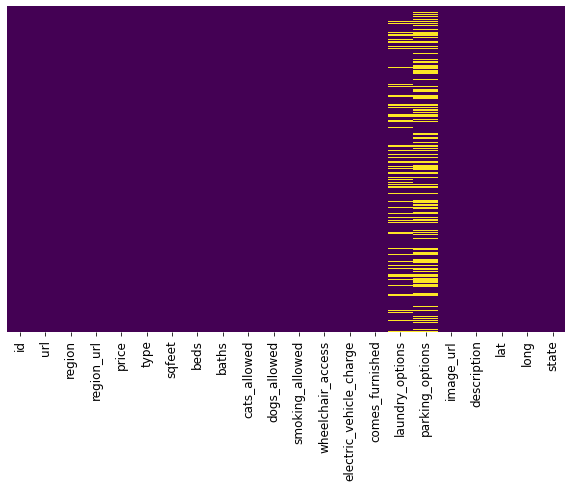

In [27]:
import seaborn as sns
plt.figure(figsize=(10, 6))
save_fig("missing_attribute_heatmap")
sns.heatmap(rentals.isnull(), yticklabels=False, cmap='viridis', cbar=False)

This will be a good dataset to work with for this template. We have both numerical (int, continuous, and binary) and categorical data, as well as missing data we have to account for. 

Here's a generalized strategy for the missing values:

- For the laundry and parking options, we can create a new category such as 'not availabe' 
- For the description option, we are only missing two descriptions and it is not an attribute that will contribute to this iteration, so we simply leave it alone, or provide a generic 'no description provided' text
- For the missing lat/long, there are several options: 
    1. We could get the region, cluster the region, and impute the mean lat/long...this would likely be the approach for operational model.
    2. We can drop these records.
    3. We can drop lat/long for our modeling purposes, or transform lat/lon features based on region and simply provide a regional lat/long.
    4. You get the idea...it depends.

For future iterations and experimentation, we have textual data describing the rental. We can further process that data and transform feature space. 

In [28]:
rentals["region"].value_counts()

jacksonville      4246
columbus          3738
rochester         3677
jackson           3667
fayetteville      3652
                  ... 
southwest MS        12
st louis             9
southwest TX         9
fort smith, AR       5
kansas city          3
Name: region, Length: 404, dtype: int64

This is interesting as well. We have some regions that are very sparse, so we will have to consider how we would like to handle these regions, in addition to state and region relations. 
We have 404 total regions. One possibile approach is to transform the dataset using regional statistical measures (or perhaps by state) and thus engineering additional attributes. 

In [29]:
rentals.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,3.849770e+05,3.849770e+05,3.849770e+05,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,384977.000000,383059.000000,383059.000000
mean,7.040982e+09,8.825722e+03,1.059900e+03,1.905345,1.480718,0.726890,0.707918,0.731771,0.082111,0.012871,0.048128,37.233487,-92.700631
std,8.800376e+06,4.462200e+06,1.915076e+04,3.494572,0.618061,0.445557,0.454721,0.443038,0.274535,0.112718,0.214036,5.546171,16.531980
min,7.003808e+09,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-43.533300,-163.894000
25%,7.035979e+09,8.050000e+02,7.500000e+02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.454700,-100.775000
50%,7.043320e+09,1.036000e+03,9.490000e+02,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.647800,-87.745100
75%,7.048426e+09,1.395000e+03,1.150000e+03,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.138300,-81.179600
max,7.051292e+09,2.768307e+09,8.388607e+06,1100.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,172.633000


In [30]:
rentals.describe().T

,count,mean,std,min,25%,50%,75%,max
id,384977.0,7.040982e+09,8.800376e+06,7.003808e+09,7.035979e+09,7.043320e+09,7.048426e+09,7.051292e+09
price,384977.0,8.825722e+03,4.462200e+06,0.000000e+00,8.050000e+02,1.036000e+03,1.395000e+03,2.768307e+09
sqfeet,384977.0,1.059900e+03,1.915076e+04,0.000000e+00,7.500000e+02,9.490000e+02,1.150000e+03,8.388607e+06
beds,384977.0,1.905345e+00,3.494572e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.100000e+03
baths,384977.0,1.480718e+00,6.180605e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,7.500000e+01
cats_allowed,384977.0,7.268902e-01,4.455574e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
dogs_allowed,384977.0,7.079176e-01,4.547206e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
smoking_allowed,384977.0,7.317710e-01,4.430381e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
wheelchair_access,384977.0,8.211140e-02,2.745347e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
electric_vehicle_charge,384977.0,1.287090e-02,1.127177e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Again, some interesting values that warrant further scrutiny. 
- 75 baths and 1100 beds with very high price and square footage values suggests we have some type of aggregated listings(condo/hotel perhaps)...or some billionaires are listing their rental properties on craigslist.  
- The max price and sq footage features have extremes in the upper quartile, suggesting we have need to clean up this dataset. 
- The min price and sq footage features have extremes (0) in the lower quartile, again suggesting we have some clean up to deal with.

We can get value counts for each category of beds, and we should do this for each attribute.

Below is a helper function to split and display numeric vs categorical data for exploratory purposes. 

In [31]:
rentals['beds'].value_counts()

2       175513
1       117226
3        67037
4        11575
0        10978
5         2324
6          240
7           49
8           31
1000         2
1100         2
Name: beds, dtype: int64

In [32]:
cat_df = rentals.select_dtypes(include=['object'])
num_df = rentals.select_dtypes(exclude=['object'])

def printColumnTypes(non_numeric_df, numeric_df):
    '''separates non-numeric and numeric columns'''
    print("Non-Numeric columns:")
    for col in non_numeric_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in numeric_df:
        print(f"{col}")
        
printColumnTypes(cat_df, num_df)

Non-Numeric columns:
url
region
region_url
type
laundry_options
parking_options
image_url
description
state

Numeric columns:
id
price
sqfeet
beds
baths
cats_allowed
dogs_allowed
smoking_allowed
wheelchair_access
electric_vehicle_charge
comes_furnished
lat
long


We can generate consolidate histogram and boxplot figures for our numerical attributes. 

Saving figure attribute_histogram_plots


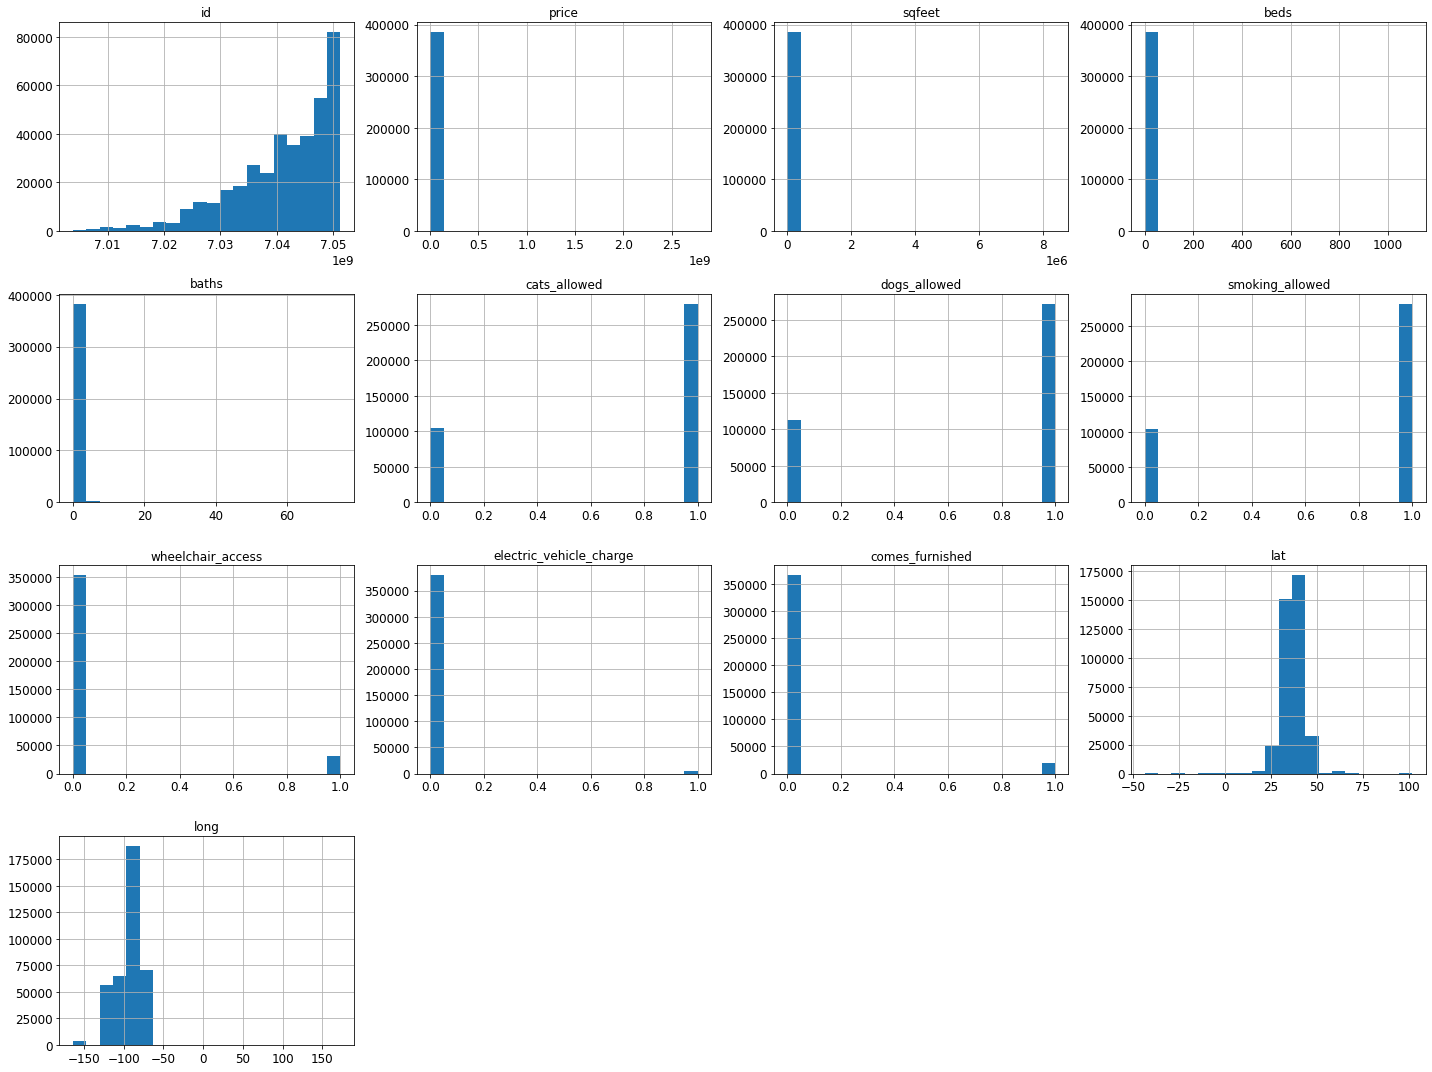

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
rentals.hist(bins=20, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

The elements required to construct a box and whisker plot outliers are given below:

Minimum value (Q0 or 0th percentile): The minimum specified value in the given dataset distribution, shown at the lower/left end.

First quartile (Q1 or 25th percentile): The first quartile (Q1) at the lower/left end, which corresponds to the area in between the minimum value and median.

Median (Q2 or 50th percentile): The median value, depicted by the line corresponding to the center of the box.

Third quartile (Q3 or 75th percentile): The third quartile (Q3) at the upper/right end, which corresponds to the area in between the median and the maximum value.

Saving figure attribute_box_plots


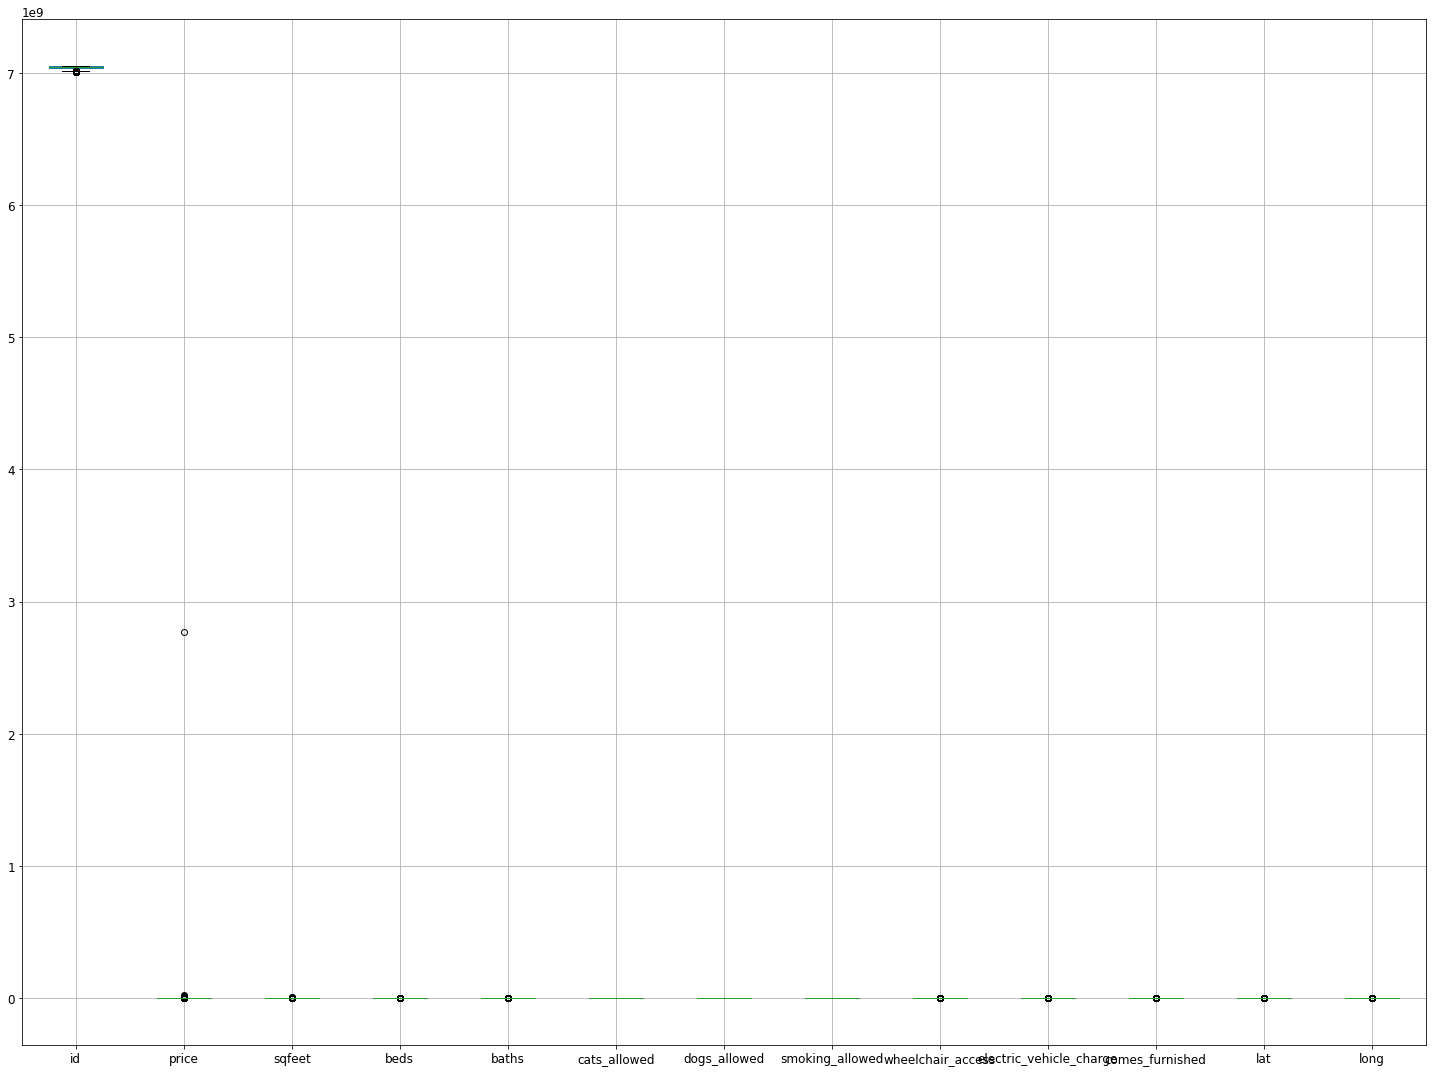

In [34]:
rentals.boxplot(figsize=(20,15))
save_fig("attribute_box_plots")
plt.show()

#histogram or box can be done for each feature individually...
#rentals.boxplot(column=['sqfeet'])

That's not helpful because of the id attribute. We could recompute without, or plot each attributed individually.


<AxesSubplot:xlabel='beds', ylabel='price'>

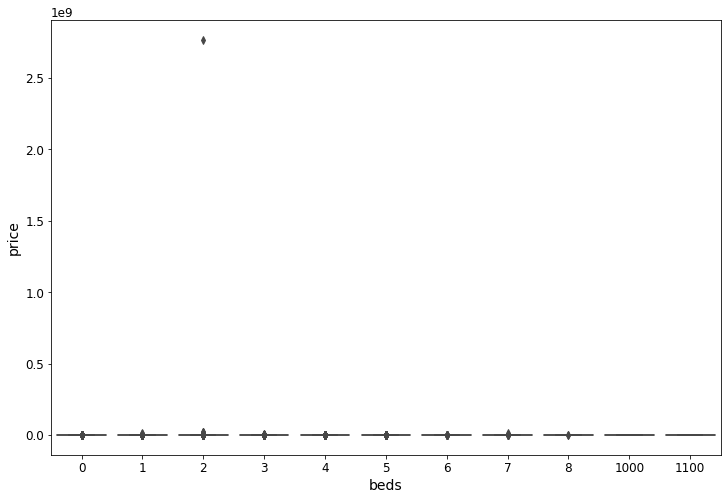

In [35]:
plt.figure(figsize=(12,8))
sns.boxplot(data=rentals, x="beds", y="price")

Let's look further into the square footage attribute. This seems it would be an important feature in the rental price. 

In [36]:
rentals["sqfeet"].max()

8388607

In [37]:
rentals.loc[rentals['sqfeet'] == 8388607]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
159607,7017516227,https://mankato.craigslist.org/apa/d/new-ulm-2...,mankato,https://mankato.craigslist.org,750,apartment,8388607,2,1.0,0,...,0,0,0,laundry in bldg,detached garage,https://images.craigslist.org/00w0w_nq1l2oBn6W...,"Description 2-bedroom, 1-bath unit with smal...",44.3262,-94.4804,mn


This lat/long is in Minneapolis and is appropriate for mankato region. However, the price per sq foot is an obvious mistake or perhaps just an outlier. Either way, we do not want this record in our dataset in this form. 

There are lots of options available. We could use metrics from the mankato region, and then impute sqfeet value for this record. For this itertions, we're going to drop the record, but you get the point. 

In [38]:
rentals["sqfeet"].min()

0

In [39]:
rentals.loc[rentals['sqfeet'] == 0].head(5)

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
32174,7049739283,https://washingtondc.craigslist.org/mld/apa/d/...,"washington, DC",https://washingtondc.craigslist.org,2200,townhouse,0,4,2.5,1,...,0,0,0,w/d in unit,street parking,https://images.craigslist.org/00101_kQEYKTJET1...,REDUCED RENT SPECIAL! Open house from 1-7pm We...,39.2998,-76.6075,dc
43679,7043879219,https://lakeland.craigslist.org/apa/d/winter-h...,lakeland,https://lakeland.craigslist.org,900,duplex,0,2,1.0,1,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00E0E_dFwnk6x3cI...,"Come Home to ""The Palms on Avenue J"" 2BR/1BA D...",28.0452,-81.7325,fl
43730,7039379473,https://lakeland.craigslist.org/apa/d/lakeland...,lakeland,https://lakeland.craigslist.org,1100,house,0,3,1.0,1,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/01212_6OBAFiUaUI...,Check Out This 3BR/1BA at the End of a Quiet ...,28.0381,-81.9392,fl
43932,7044641620,https://lakeland.craigslist.org/apa/d/lakeland...,lakeland,https://lakeland.craigslist.org,1100,house,0,3,1.0,1,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/01212_6OBAFiUaUI...,Check Out This 3BR/1BA at the End of a Quiet ...,28.0381,-81.9392,fl
44270,7039379070,https://lakeland.craigslist.org/apa/d/lakeland...,lakeland,https://lakeland.craigslist.org,1100,house,0,3,1.0,1,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/01212_6OBAFiUaUI...,Check Out This 3BR/1BA at the End of a Quiet ...,28.0381,-81.9392,fl


So, maybe 0 is just sq feet missing, but the 8.3 million square foot rental is likely an error as we mentioned earlier. Same thought process applies to the 0 sq foot listings. We could impute these values if we want to keep the records in the dataset.

For this iteration, we'll prune the dataset by price and sq footage.

The next series of code modules are presented  as exploration ideas and examples. 

When using dataframes in python, there are many methods available. We list a few worth a look:

- assign 

lets you add columns
- map

mapping 

extract rows
- explode

to create new rows from columnar lists
- apply

use with lambda to insert function

- logical operators

&, |, ~




<AxesSubplot:xlabel='price', ylabel='sqfeet'>

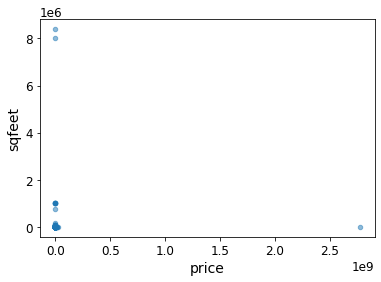

In [40]:
rentals.plot(kind="scatter", x="price", y="sqfeet", alpha=0.5)

In [41]:
rentals["price"].max()

2768307249

In [42]:
rentals.loc[rentals['price'] == 2768307249]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
74809,7035456041,https://columbusga.craigslist.org/apa/d/columb...,columbus,https://columbusga.craigslist.org,2768307249,apartment,1118,2,1.5,1,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00V0V_7KSQPod9NT...,Club Hill has a Raleigh Floorplan ready for Pr...,32.4779,-84.898,ga


In [43]:
rentals["price"].min()

0

In [44]:
rentals.loc[rentals['price'] == 0]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
2205,7045432807,https://sacramento.craigslist.org/apa/d/sacram...,sacramento,https://sacramento.craigslist.org,0,apartment,500,1,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00W0W_8j3w1zIbjb...,"At California Place Apartments, we believe tha...",38.4718,-121.427,ca
3351,7045301138,https://sacramento.craigslist.org/apa/d/sacram...,sacramento,https://sacramento.craigslist.org,0,apartment,500,1,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00y0y_l039xPNU8X...,"At California Place Apartments, we believe tha...",38.4718,-121.427,ca
3375,7048608931,https://sacramento.craigslist.org/apa/d/sacram...,sacramento,https://sacramento.craigslist.org,0,apartment,500,1,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00202_lrdD3s9Xht...,"At California Place Apartments, we believe tha...",38.4718,-121.427,ca
3474,7048563314,https://sacramento.craigslist.org/apa/d/sacram...,sacramento,https://sacramento.craigslist.org,0,apartment,500,1,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00q0q_jzDlkzUEEm...,California Place Apartments stand three storie...,38.4718,-121.427,ca
3486,7048500513,https://sacramento.craigslist.org/apa/d/sacram...,sacramento,https://sacramento.craigslist.org,0,apartment,500,1,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00101_ghilg4hSW7...,"At California Place Apartments, we believe tha...",38.4718,-121.427,ca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381619,7047534104,https://orangecounty.craigslist.org/apa/d/west...,orange county,https://orangecounty.craigslist.org,0,apartment,1000,2,0.0,1,...,0,0,0,laundry on site,carport,https://images.craigslist.org/00g0g_eDA78csE9a...,CALESPAÃA APARTMENT HOMES WESTMINSTER -\tGA...,33.7524,-117.994,ca
381925,7049400936,https://orangecounty.craigslist.org/apa/d/sant...,orange county,https://orangecounty.craigslist.org,0,apartment,446,0,1.0,0,...,0,0,0,laundry in bldg,carport,https://images.craigslist.org/01313_drIAE74V35...,The Imperial Apartments Pricing: - $1960 / m...,33.7691,-117.885,ca
382005,7047532633,https://orangecounty.craigslist.org/apa/d/west...,orange county,https://orangecounty.craigslist.org,0,apartment,750,1,1.0,1,...,0,0,0,laundry on site,carport,https://images.craigslist.org/00G0G_hCgkDPMBM5...,CALESPAÃA APARTMENT HOMES WESTMINSTER -\tGA...,33.7524,-117.994,ca
382063,7049275559,https://orangecounty.craigslist.org/apa/d/sant...,orange county,https://orangecounty.craigslist.org,0,apartment,446,0,1.0,0,...,0,0,0,laundry in bldg,carport,https://images.craigslist.org/01313_drIAE74V35...,Come home to a great community - The Imperial ...,33.7691,-117.885,ca


In [45]:
rentals["price"].value_counts()[0]

1307

In [46]:
(rentals["price"]>1000000).sum()

14

In [47]:
(rentals["price"]>5000).sum()

951

In [48]:
(rentals["price"]<100).sum()

2214

If we determined that our best approach is to remove the listing with price > $5,000, we can do that via the drop method and then use that dataframe for further exploration. 

In [49]:
rentals.drop(rentals[rentals['price'] > 5000].index, inplace=True)
rentals.shape

(384026, 22)

In [50]:
rentals.drop(rentals[rentals['price'] < 150].index, inplace=True)
rentals.shape

(381751, 22)

<AxesSubplot:xlabel='price', ylabel='sqfeet'>

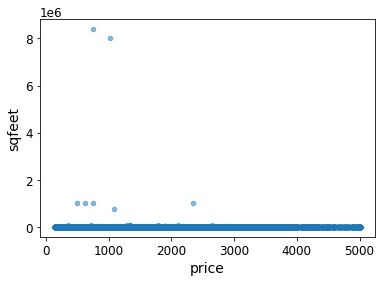

In [51]:
rentals.plot(kind="scatter", x="price", y="sqfeet", alpha=0.5)

In [52]:
rentals.groupby(["region"])["price"].sum()

region
SF bay area               6169479
abilene                    712685
akron / canton            1298029
albany                    2172575
albuquerque               1886077
                           ...   
york                       658649
youngstown                 196153
yuba-sutter                227514
yuma                       175589
zanesville / cambridge     166632
Name: price, Length: 404, dtype: int64

In [53]:
(rentals["sqfeet"]>4000).sum()

334

In [54]:
rentals.drop(rentals[(rentals['sqfeet'] > 4000)].index, inplace=True)
rentals.shape

(381417, 22)

In [55]:
rentals.drop(rentals[(rentals['sqfeet'] < 150)].index, inplace=True)
rentals.shape

(380372, 22)

<AxesSubplot:xlabel='price', ylabel='sqfeet'>

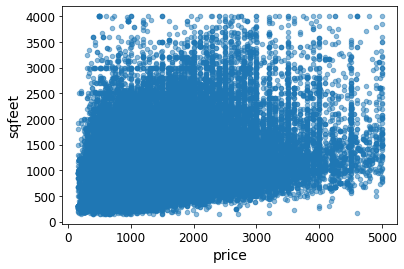

In [56]:
rentals.plot(kind="scatter", x="price", y="sqfeet", alpha=0.5)

<AxesSubplot:xlabel='price'>

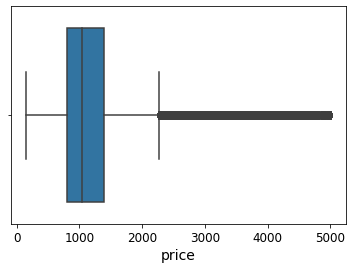

In [57]:
sns.boxplot(x="price", data=rentals)

We can go back and look at our beds boxplot

<AxesSubplot:xlabel='beds', ylabel='price'>

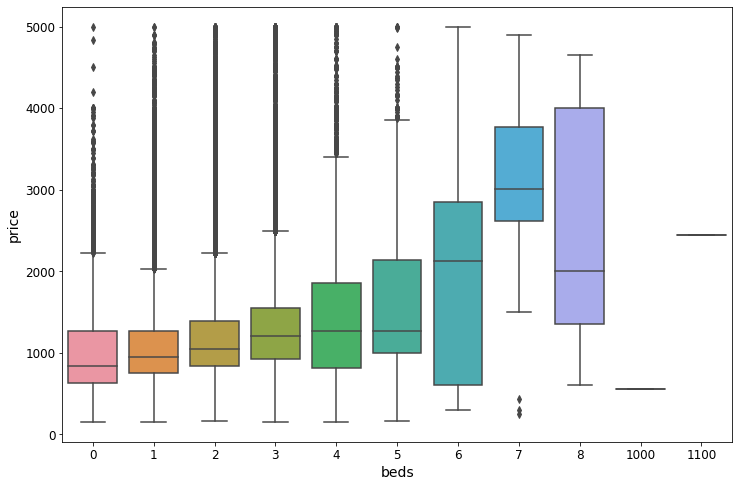

In [58]:
plt.figure(figsize=(12,8))
sns.boxplot(data=rentals, x="beds", y="price")

In [59]:
rentals.drop(rentals[(rentals['beds'] > 8)].index, inplace=True)
rentals.shape

(380369, 22)

<AxesSubplot:xlabel='beds', ylabel='price'>

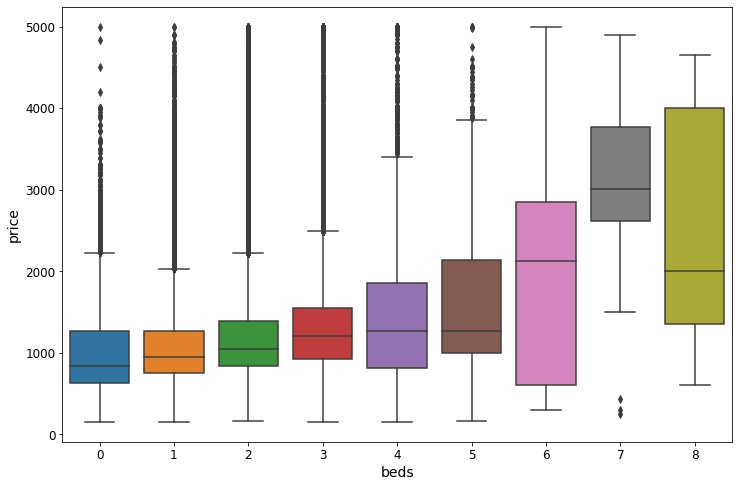

In [60]:
plt.figure(figsize=(12,8))
sns.boxplot(data=rentals, x="beds", y="price")

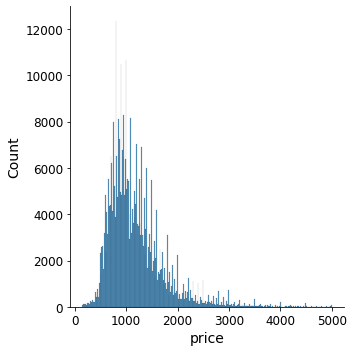

In [61]:
sns.displot(rentals["price"])

<AxesSubplot:xlabel='sqfeet'>

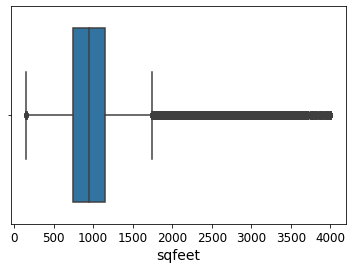

In [62]:
sns.boxplot(x="sqfeet", data=rentals)

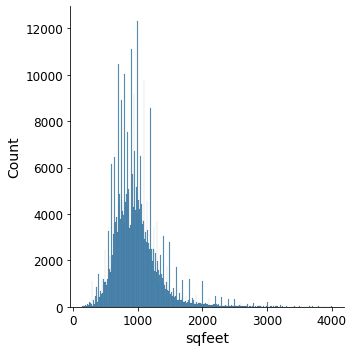

In [63]:
sns.displot(rentals["sqfeet"])

In [64]:
rentals.groupby(["state"])["region"].count()

state
ak     2148
al     8172
ar     3133
az     6611
ca    32260
co    11239
ct     3738
dc     2465
de     2031
fl    31711
ga    13751
hi     1800
ia     7427
id     4425
il     9633
in     6384
ks     7794
ky     5406
la     7211
ma     4786
md     7408
me      414
mi    14407
mn     7398
mo     2144
ms     4849
mt     1313
nc    18357
nd     3403
ne     2671
nh     1752
nj     5662
nm     2771
nv     2812
ny     9806
oh    12691
ok     5749
or     8031
pa     9783
ri     1874
sc     9896
sd     1768
tn    11408
tx    30716
ut     5121
va    10955
vt      518
wa     7003
wi     6575
wv      803
wy      186
Name: region, dtype: int64

In [65]:
rentals.loc[(rentals["state"]=='ca') & (rentals["price"] == 1724)]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
1989,7045533961,https://sacramento.craigslist.org/apa/d/rosevi...,sacramento,https://sacramento.craigslist.org,1724,apartment,1040,2,2.0,1,...,0,0,0,w/d hookups,detached garage,https://images.craigslist.org/00p0p_aXLIsBSJPM...,"Nestled within beautiful Roseville, California...",38.7609,-121.287,ca
2203,7047591372,https://sacramento.craigslist.org/apa/d/rosevi...,sacramento,https://sacramento.craigslist.org,1724,apartment,1040,2,2.0,1,...,0,0,0,w/d hookups,detached garage,https://images.craigslist.org/00L0L_cDD7K1oKl2...,"Nestled within beautiful Roseville, California...",38.7609,-121.287,ca
2307,7047592372,https://sacramento.craigslist.org/apa/d/rosevi...,sacramento,https://sacramento.craigslist.org,1724,apartment,1040,2,2.0,1,...,0,0,0,w/d hookups,detached garage,https://images.craigslist.org/00C0C_4KgPFZ4WZj...,"Nestled within beautiful Roseville, California...",38.7609,-121.287,ca
2368,7047592545,https://sacramento.craigslist.org/apa/d/rosevi...,sacramento,https://sacramento.craigslist.org,1724,apartment,1040,2,2.0,1,...,0,0,0,w/d hookups,detached garage,https://images.craigslist.org/00l0l_8mXAmQgHr1...,"Nestled within beautiful Roseville, California...",38.7609,-121.287,ca
2563,7047594855,https://sacramento.craigslist.org/apa/d/rosevi...,sacramento,https://sacramento.craigslist.org,1724,apartment,1040,2,2.0,1,...,0,0,0,w/d hookups,detached garage,https://images.craigslist.org/00l0l_8mXAmQgHr1...,"Nestled within beautiful Roseville, California...",38.7609,-121.287,ca
3673,7050098413,https://sandiego.craigslist.org/nsd/apa/d/san-...,san diego,https://sandiego.craigslist.org,1724,apartment,650,0,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00k0k_4R0tWFbmqR...,"WELCOME TO MARC â a synergy of design, livin...",33.1444,-117.170,ca
4227,7049950136,https://sandiego.craigslist.org/csd/apa/d/san-...,san diego,https://sandiego.craigslist.org,1724,apartment,600,1,1.0,1,...,0,0,0,laundry in bldg,carport,https://images.craigslist.org/01111_kHD0h11CGJ...,"Gables Point Loma, managed by Gables Residenti...",32.7512,-117.220,ca
5004,7049746865,https://sandiego.craigslist.org/nsd/apa/d/san-...,san diego,https://sandiego.craigslist.org,1724,apartment,650,0,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00H0H_aeReix3Mpb...,"WELCOME TO MARC â a synergy of design, livin...",33.1444,-117.170,ca
5882,7049408261,https://sandiego.craigslist.org/nsd/apa/d/san-...,san diego,https://sandiego.craigslist.org,1724,apartment,650,0,1.0,0,...,0,0,0,NaN,NaN,https://images.craigslist.org/00k0k_4R0tWFbmqR...,"WELCOME TO MARC â a synergy of design, livin...",33.1444,-117.170,ca
378342,7041639738,https://modesto.craigslist.org/apa/d/modesto-i...,modesto,https://modesto.craigslist.org,1724,apartment,1055,2,2.0,1,...,0,0,0,w/d in unit,carport,https://images.craigslist.org/00I0I_es6u428EiJ...,Right when you walk into this beautiful 2 bedr...,37.6717,-120.948,ca


No duplicate listings

In [66]:
rentals['id'].unique

<bound method Series.unique of 0         7049044568
1         7049047186
2         7043634882
3         7049045324
4         7049043759
             ...    
384972    7049053337
384973    7049052968
384974    7049050454
384975    7049050149
384976    7049050010
Name: id, Length: 380369, dtype: int64>

In [67]:
rentals.shape

(380369, 22)

In [76]:
(rentals["sqfeet"]>3000).sum()

831

We have a very tail-heavy distribution with sqfeet attribute. A method we could use when we start to build our final dataset for ML pipeline is to use the log distribution instead.

<AxesSubplot:>

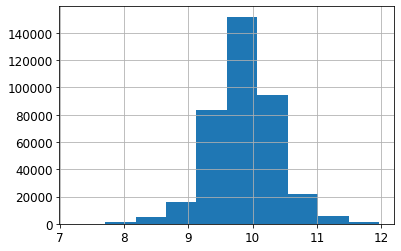

In [77]:
log_sqfeet = np.log2(rentals["sqfeet"])
log_sqfeet.hist()

Saving figure lat_long_world


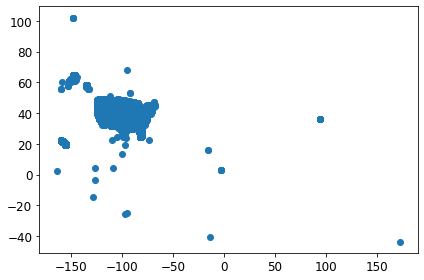

In [78]:
plt.scatter(x=rentals['long'], y=rentals['lat'])
save_fig("lat_long_world")
plt.show()

This basic plot tells us visually we have listing outside the US. Again, there are a lot of options on how we handle this. We could get region centroids and impute that value for some of these records. We'll do something similar, but we will drop records based on median values of regional lat/longs within the dataset. 

In [80]:
(rentals['long']>-50).sum()

249

In [81]:
rentals.drop(rentals[rentals['long'] > -50].index, inplace=True)

Saving figure lat_long_world


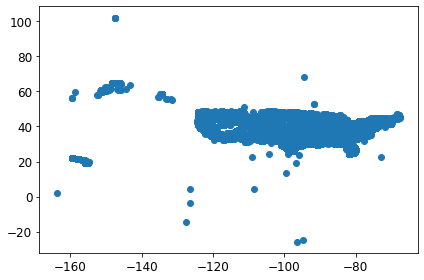

In [82]:
plt.scatter(x=rentals['long'], y=rentals['lat'])
save_fig("lat_long_world")
plt.show()

In [83]:
rentals.loc[(rentals["lat"] < 20) & (rentals['region']=='pensacola')]

,id,url,region,region_url,price,type,sqfeet,beds,baths,cats_allowed,...,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,image_url,description,lat,long,state
53417,7038693189,https://pensacola.craigslist.org/apa/d/two-bed...,pensacola,https://pensacola.craigslist.org,750,duplex,600,2,1.0,1,...,0,0,0,w/d hookups,off-street parking,https://images.craigslist.org/00q0q_8LLOmLhAov...,Two bedroom one bathroom with carpet. Eat in k...,4.12942,-126.474,fl


Pensacola true lat/long = 30.433283, -87.240372. We have similar cases with a handful of samples. Depending on the relevance to the use case, we could pursue these discrepancies in a number of ways. For example, we find obtain each region's central lat/long (or compute a mean from the samples) and then remove lat/long based on specific measure. We could run unsupervised clustering algorithm on regions to identify outliers. 

Quick scatterplot of pensacola region shows we have several erroneous sample labels for this one region. So, it is likely that all regions are affected and we need some mitigation strategy. 



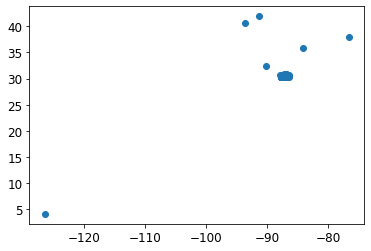

In [84]:
# condition mask
mask = rentals['region'] == 'pensacola'
  
# new dataframe with selected rows
pensacola_rentals = pd.DataFrame(rentals[mask])

plt.scatter(x=pensacola_rentals['long'], y=pensacola_rentals['lat'])
plt.show()


We'll keep it simple for this first iteration so that we can more quickly get to the modeling part of the template. 

Let's compute the mean and medians for pensacola lat/long.

We can write a helper function, or with pandas, we can use aggregation. 

In [85]:
def location_measures(df):

        lat_mean = df['lat'].mean()
        lat_median = df['lat'].median()
        lat_std = df['lat'].std()

        long_mean = df['long'].mean()
        long_median = df['long'].median()
        long_std = df['long'].std()
        print('{} => {}'.format("Lat Mean", lat_mean))
        print('{} => {}'.format("Lat Median", lat_median))
        print('{} => {}'.format("Lat SD", lat_std))
        print('{} => {}'.format("Long Mean", long_mean))
        print('{} => {}'.format("Long Median", long_median))
        print('{} => {}'.format("Lat SD", long_std))

location_measures(pensacola_rentals)  
    

Lat Mean => 30.47760627402356
Lat Median => 30.48
Lat SD => 0.7963217379983741
Long Mean => -87.27120384376938
Long Median => -87.2231
Lat SD => 1.0417138177955638


In [86]:
pensacola_rentals.groupby(by=['region'],as_index=False)[['lat','long']].agg(['mean','median','min','max','std'])

lat                                          long           \
                mean median      min      max       std       mean   median   
region                                                                        
pensacola  30.477606  30.48  4.12942  41.9287  0.796322 -87.271204 -87.2231   

                                       
               min      max       std  
region                                 
pensacola -126.474 -76.6367  1.041714

We're going to use the median for each region as a simple centroid and then drop any records that fall outside a predetermined distance to that median location. 

Again, lots of ways to do this, but we'll use a purely intuitive approach. Since 1 degree of latitude is ~ 60 nm, and 1 degree of longitude is ~50 nm in US, we can drop any locations that fall outside of some bounds. We'll use this median and 120 miles, which is reasonable for our purposes, applying the haversine function to get distance. Some regions that cover sparsely populated areas may be much larger, and again, we would want to refine this method for some production model. We're going for expediency here:)

In [87]:
# we'll rewrite location_measures to handle all regions

df_region_locations = rentals.groupby(by=['region'])[['lat','long']].agg(['mean','median','min','max','std']).reset_index()
df_region_locations



region        lat                                       \
                                  mean   median      min      max       std   
0               SF bay area  37.651010  37.6695  33.6416  39.4493  0.352090   
1                   abilene  32.419231  32.4066  30.0957  40.6830  0.305539   
2            akron / canton  41.095612  41.1377  34.9583  43.1378  0.267274   
3                    albany  38.278202  42.6560  30.7853  46.2117  5.481732   
4               albuquerque  35.127481  35.1308  33.5943  40.1559  0.169520   
..                      ...        ...      ...      ...      ...       ...   
399                    york  39.937553  39.9494  39.2789  40.2960  0.115125   
400              youngstown  41.126308  41.1042  40.4014  41.3600  0.113517   
401             yuba-sutter  39.024595  39.0861  32.9941  39.5976  0.707418   
402                    yuma  32.699249  32.7015  32.5672  33.9776  0.089531   
403  zanesville / cambridge  40.020953  40.0427  39.5385  40.3389  0.075677   

           long                                          
           mean    median       min       max       std  
0   -122.127585 -122.0680 -123.3680 -115.5270  0.344564  
1    -99.734830  -99.7746 -103.1010  -75.2878  0.856213  
2    -81.514600  -81.5409 -122.4120  -74.1816  1.146642  
3    -78.014505  -73.8883 -119.1670  -73.1923  5.214802  
4   -106.601221 -106.5780 -116.5130 -105.0960  0.294287  
..          ...       ...       ...       ...       ...  
399  -76.703396  -76.6891  -77.4464  -75.8415  0.149395  
400  -80.741670  -80.6945  -81.7850  -80.0829  0.172515  
401 -121.244893 -121.5500 -122.0280  -78.9759  3.486816  
402 -114.612972 -114.6420 -114.7890 -113.5030  0.106488  
403  -82.293038  -82.4566  -82.5318  -81.4580  0.278373  

[404 rows x 11 columns]

In [88]:
stats = ['mean','median','min','max','std']
df_region_locations.columns = ['region']+ ['lat_{}'.format(stat) for stat in stats]+['long_{}'.format(stat) for stat in stats]
df_region_locations

,region,lat_mean,lat_median,lat_min,lat_max,lat_std,long_mean,long_median,long_min,long_max,long_std
0,SF bay area,37.651010,37.6695,33.6416,39.4493,0.352090,-122.127585,-122.0680,-123.3680,-115.5270,0.344564
1,abilene,32.419231,32.4066,30.0957,40.6830,0.305539,-99.734830,-99.7746,-103.1010,-75.2878,0.856213
2,akron / canton,41.095612,41.1377,34.9583,43.1378,0.267274,-81.514600,-81.5409,-122.4120,-74.1816,1.146642
3,albany,38.278202,42.6560,30.7853,46.2117,5.481732,-78.014505,-73.8883,-119.1670,-73.1923,5.214802
4,albuquerque,35.127481,35.1308,33.5943,40.1559,0.169520,-106.601221,-106.5780,-116.5130,-105.0960,0.294287
...,...,...,...,...,...,...,...,...,...,...,...
399,york,39.937553,39.9494,39.2789,40.2960,0.115125,-76.703396,-76.6891,-77.4464,-75.8415,0.149395
400,youngstown,41.126308,41.1042,40.4014,41.3600,0.113517,-80.741670,-80.6945,-81.7850,-80.0829,0.172515
401,yuba-sutter,39.024595,39.0861,32.9941,39.5976,0.707418,-121.244893,-121.5500,-122.0280,-78.9759,3.486816
402,yuma,32.699249,32.7015,32.5672,33.9776,0.089531,-114.612972,-114.6420,-114.7890,-113.5030,0.106488


In [89]:
# this is not a clean implementation
from haversine import haversine, Unit

def CleanLocations(df1, df2):
    for index, row in df1.iterrows():

        row_data = df1.loc[ index , : ]
        median_location = (row_data['lat_median'], row_data['long_median'])
        rgn = (row_data['region'])
        df3 = df2.loc[df2['region'] == rgn]
         
        for index2, row in df3.iterrows():
            row_data2 = df3.loc[index2, : ]
            sample_location = (row_data2['lat'], row_data2['long'])
           
            if (haversine(median_location, sample_location, unit=Unit.MILES) > 150):
                df2.drop(index2, inplace=True)
    #return df2
    
CleanLocations(df_region_locations, pensacola_rentals)


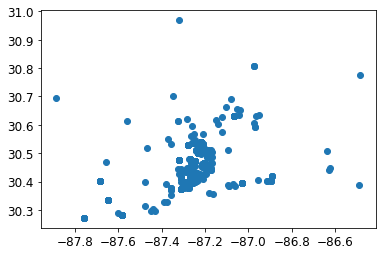

In [90]:
plt.scatter(x=pensacola_rentals['long'], y=pensacola_rentals['lat'])
plt.show()


That looks better for pensacola region, and we can apply that to the entire dataset...this will take some computing time. Perhaps we want to quarantine the records we dropped and see if they actually fall into another region by correlating url and lat/long, but we'll leave that for an exercise. 

In [91]:
rentals.describe()

,id,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,3.801200e+05,380120.000000,380120.000000,380120.000000,380120.000000,380120.000000,380120.000000,380120.000000,380120.000000,380120.000000,380120.000000,378222.000000,378222.000000
mean,7.040986e+09,1177.922843,990.801352,1.889864,1.476851,0.728854,0.709558,0.732419,0.081998,0.012812,0.047048,37.239638,-92.779760
std,8.799562e+06,547.625646,367.569847,0.872190,0.583337,0.444552,0.453967,0.442699,0.274362,0.112462,0.211742,5.545373,15.822471
min,7.003808e+09,150.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25.661800,-163.894000
25%,7.035984e+09,811.000000,750.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.453100,-99.774600
50%,7.043324e+09,1040.000000,949.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.663700,-87.698600
75%,7.048428e+09,1395.000000,1149.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.146650,-81.196600
max,7.051292e+09,5000.000000,4000.000000,8.000000,7.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,102.036000,-67.482000


In [92]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380120 entries, 0 to 384976
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       380120 non-null  int64  
 1   url                      380120 non-null  object 
 2   region                   380120 non-null  object 
 3   region_url               380120 non-null  object 
 4   price                    380120 non-null  int64  
 5   type                     380120 non-null  object 
 6   sqfeet                   380120 non-null  int64  
 7   beds                     380120 non-null  int64  
 8   baths                    380120 non-null  float64
 9   cats_allowed             380120 non-null  int64  
 10  dogs_allowed             380120 non-null  int64  
 11  smoking_allowed          380120 non-null  int64  
 12  wheelchair_access        380120 non-null  int64  
 13  electric_vehicle_charge  380120 non-null  int64  
 14  come

Some descriptive statistics on the dataset

In [288]:
from scipy.stats import skew, skewtest, norm, kurtosis, boxcox
import scipy.stats as st

rentals['price'].describe()

count    367536.000000
mean       1184.704992
std         548.647813
min         150.000000
25%         820.000000
50%        1050.000000
75%        1400.000000
max        5000.000000
Name: price, dtype: float64

Our mean is greater than our median, and the max is over 3x the 75% value. We have positive skewness in the data and most of our rental listing are below the average. 

c:\Users\eh172\Desktop\DS Research\Scripts\ML_pipelines\ml-env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<function matplotlib.pyplot.show(close=None, block=None)>

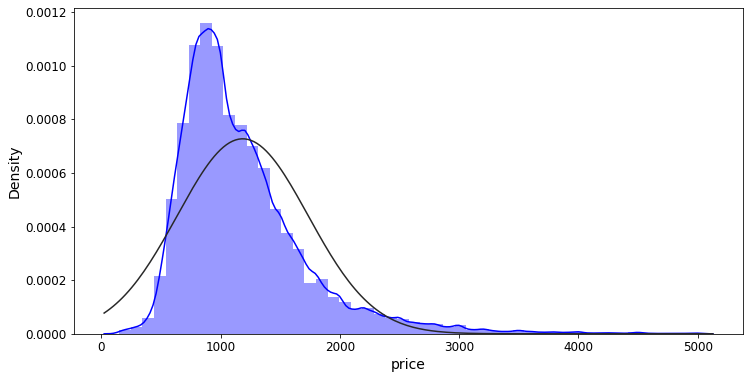

In [291]:
plt.figure(figsize=(12,6))
sns.distplot(rentals['price'],fit=norm, color ='b')
plt.show

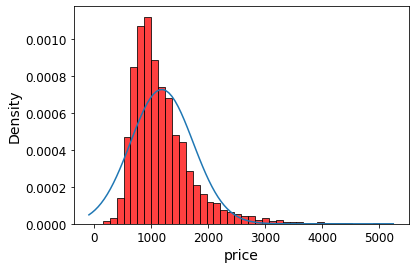

In [309]:
ax = sns.histplot(rentals['price'], bins=40, stat='density', color='r')

mu, std = stats.norm.fit(rentals['price'])
xx = np.linspace(*ax.get_xlim(),100)
ax.plot(xx, stats.norm.pdf(xx, mu, std))

This histogram shows the positive skew

In [297]:
rentals['price'].skew()

1.9134688658541545

In [298]:
kurtosis(rentals['price'], fisher=False)

8.922041149721768

In [312]:
rentals['log_price'] = np.log(rentals['price'])

skew post transform:  0.2244401141752586
kurt post transform:  3.6966142302609475


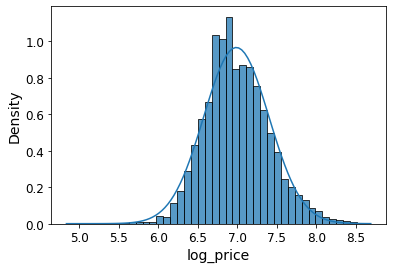

In [313]:
ax = sns.histplot(rentals['log_price'], bins=40, stat='density')

mu, std = stats.norm.fit(rentals['log_price'])
xx = np.linspace(*ax.get_xlim(),100)
ax.plot(xx, stats.norm.pdf(xx, mu, std))

print("skew post transform: ", rentals['log_price'].skew())

print("kurt post transform: ", kurtosis(rentals['log_price'], fisher=False))

We have to be careful when we transform data in this manner, especially with nonlinear relations. Nevertheless, we could get more normally distributed variables, and perhaps better model performance fitting by the transformation. We would want to compare results over some combinations.  

In [304]:
rentals.drop(columns=["log_price"],axis=0,inplace=True)

Visualizations are helpful to explore data. With this simple lat/long scatter plot, we can see the outline of the US as well as the listing locations outside the US. 

We will not get into the various visualization techniques and libraries in this iteration...with the below exception. 

The below module produces a basic plotly world map and overlays the listings. It is commented out in this template, and requires plotly, jupyterlab, nbformat, and keliedo installs. 

# DON'T render the map inside of your IDE.
Export the images as html (interactive) and png (static) files. The interactive image can be opened in the web browser. This one produces 13MB file, so it is very large and could be slow depending on system. 

In [93]:
import plotly.express as px
fig = px.scatter_geo(rentals, lat='lat', lon='long', color="region", # which column to use to set the color of markers 
                    hover_name="region", # column added to hover information
                    size="price", # size of markers
                    projection="natural earth")

fig.write_html("images1/end_to_end_1/worldmap.html")
fig.write_image("images1/end_to_end_1/worldmap.png")
#fig.show()

Two more plots, this time by state (California for this example). The california and florida png files are static images that we load in the notebook. 

The prices are higher along the coast as one would expect, and parts of NV (i.e., reno/tahoe area) are labeled as California.

Saving figure ca_rental_prices_plot


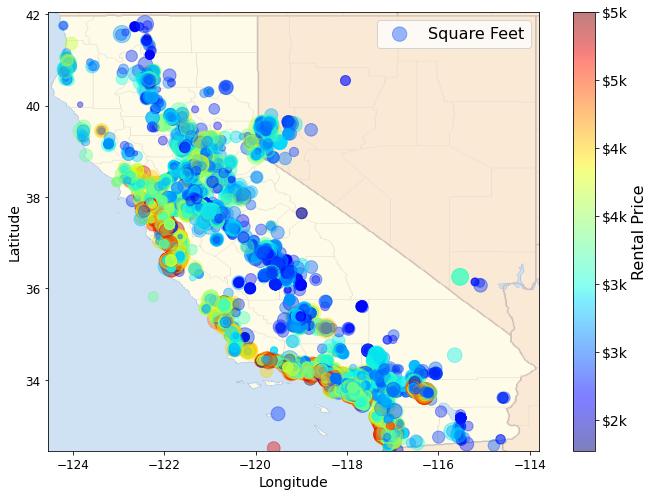

In [94]:
# condition mask
mask = rentals['state'] == 'ca'
  
# new dataframe with selected rows
df_new = pd.DataFrame(rentals[mask])

import matplotlib.image as mpimg
images_path = os.path.join(PROJECT_ROOT_DIR, "images1", "end_to_end_1")
filename = "california.png"

us_img=mpimg.imread(os.path.join(images_path, filename))
ax = df_new.plot(kind="scatter", x="long", y="lat", figsize=(10,7),
                  s=df_new['sqfeet']/10, label="Square Feet",
                  c="price", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(us_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df_new["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Rental Price', fontsize=16)

plt.legend(fontsize=16)
save_fig("ca_rental_prices_plot")
plt.show()

And Florida...

Saving figure fl_rental_prices_plot


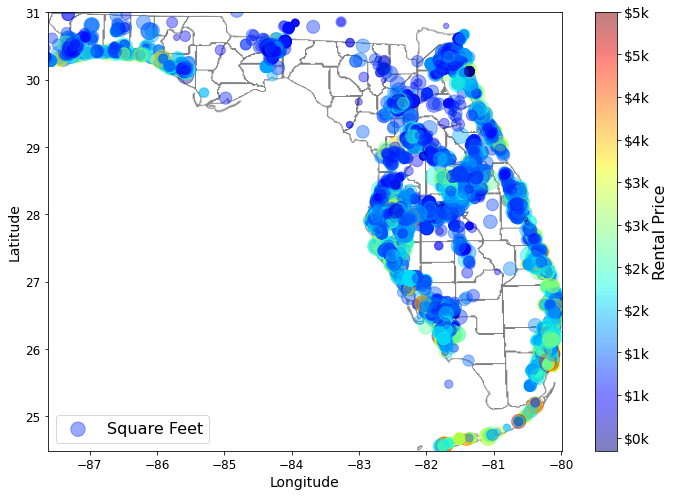

In [95]:
# condition mask
mask = rentals['state'] == 'fl'
  
# new dataframe with selected rows
fl_df = pd.DataFrame(rentals[mask])

import matplotlib.image as mpimg
images_path = os.path.join(PROJECT_ROOT_DIR, "images1", "end_to_end_1")
filename = "florida.png"

us_img=mpimg.imread(os.path.join(images_path, filename))
ax = fl_df.plot(kind="scatter", x="long", y="lat", figsize=(10,7),
                  s=fl_df['sqfeet']/10, label="Square Feet",
                  c="price", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(us_img, extent=[-87.627, -79.991, 24.487, 31.006], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = fl_df["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Rental Price', fontsize=16)

plt.legend(fontsize=16)
save_fig("fl_rental_prices_plot")
plt.show()

In [96]:
fl_df["region"].value_counts()

jacksonville             2579
orlando                  2562
space coast              2499
sarasota-bradenton       2429
daytona beach            2384
lakeland                 2322
tampa bay area           2133
ft myers / SW florida    2068
tallahassee              1978
gainesville              1964
treasure coast           1751
panama city              1633
pensacola                1613
south florida            1397
okaloosa / walton         941
ocala                     563
florida keys              442
heartland florida         246
st augustine              179
north central FL           28
Name: region, dtype: int64

In [97]:
fl_df.shape

(31711, 22)

At this point, we're going to drop some columns. We can always get them back if necessary, and we wouldn't do this without first going through a more thorough analysis of the attributes to be dropped. 

We dropped the following:
1. id - unique identifier for each listing. We could (should) keep if we expect to add data and reuse this model as a means to ensure train/test consistency. 
2. url - self explanatory
3. region_url - same
4. image_url - same same
5. description - text narrative. 
6. state - we'll drop state because we have regions, and that is more informative for this exercise. We could analyze by region within state, and that we can put back together if desired. 
 

In [98]:
rentals.drop(columns=["id", "url", "region_url", "image_url", 
                 "description", "state"],axis=0,inplace=True)

In [99]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380120 entries, 0 to 384976
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   380120 non-null  object 
 1   price                    380120 non-null  int64  
 2   type                     380120 non-null  object 
 3   sqfeet                   380120 non-null  int64  
 4   beds                     380120 non-null  int64  
 5   baths                    380120 non-null  float64
 6   cats_allowed             380120 non-null  int64  
 7   dogs_allowed             380120 non-null  int64  
 8   smoking_allowed          380120 non-null  int64  
 9   wheelchair_access        380120 non-null  int64  
 10  electric_vehicle_charge  380120 non-null  int64  
 11  comes_furnished          380120 non-null  int64  
 12  laundry_options          301947 non-null  object 
 13  parking_options          241068 non-null  object 
 14  lat 

Let's go ahead and clean up the regions for the dataset in the manner we did earlier for pensaocola. This takes a little bit of time (~ 15 minutes max) and could be rewritten to make much more efficient. We do this inplace on the existing dataframe, but could return a reduced copy if desired. More dataframes = more memory usage. 

In [100]:
CleanLocations(df_region_locations, rentals)

Saving figure lat_long_world_reduced


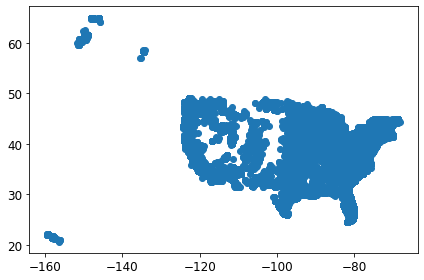

In [101]:
plt.scatter(x=rentals['long'], y=rentals['lat'])
save_fig("lat_long_world_reduced")
plt.show() 

Ok, now that resembles a map of the U.S. a little better than before. 

We've done a lot of data exploration and that is part of every data project. We will switch gears now and select a dataset, engineer some features, clean the dataset, and apply ML algorithmic models to the dataset to predict rental prices. 

We are going to stick with our reduced dataset based on our price/sq footage trimming. 


Save in case we want to pick up here. 

In [102]:
save_csv('rentals', rentals)

Saving file rentals


In [104]:
# we can reload csv from this point if necessary

# import pandas as pd

# csv_path = os.path.join(LOCAL_PATH, "rentals.csv")
# rentals2 = pd.read_csv(csv_path)

In [106]:
rentals.isnull().sum()

region                          0
price                           0
type                            0
sqfeet                          0
beds                            0
baths                           0
cats_allowed                    0
dogs_allowed                    0
smoking_allowed                 0
wheelchair_access               0
electric_vehicle_charge         0
comes_furnished                 0
laundry_options             75507
parking_options            135408
lat                          1898
long                         1898
dtype: int64

It is likely that electric vehicle charge is not helpful to the model, but we'll leave it in for this template.

In [107]:
rentals['comes_furnished'].value_counts()

0    352180
1     17254
Name: comes_furnished, dtype: int64

In [108]:
rentals['electric_vehicle_charge'].value_counts()

0    364729
1      4705
Name: electric_vehicle_charge, dtype: int64

In [109]:
rentals['wheelchair_access'].value_counts()

0    339261
1     30173
Name: wheelchair_access, dtype: int64

laundry_options - create unknown category
parking_options - create unknown category
lat/long - drop null

In [110]:
rentals['laundry_options'].value_counts()

w/d in unit           127062
w/d hookups            72357
laundry on site        56260
laundry in bldg        34906
no laundry on site      3342
Name: laundry_options, dtype: int64

In [111]:
rentals.laundry_options.fillna('unknown',inplace = True)

In [112]:
rentals['laundry_options'].value_counts()

w/d in unit           127062
unknown                75507
w/d hookups            72357
laundry on site        56260
laundry in bldg        34906
no laundry on site      3342
Name: laundry_options, dtype: int64

In [113]:
rentals['parking_options'].value_counts()

off-street parking    122377
attached garage        38269
carport                38144
detached garage        16479
street parking         15487
no parking              3119
valet parking            151
Name: parking_options, dtype: int64

In [114]:
rentals.parking_options.fillna('unknown',inplace = True)
rentals['parking_options'].value_counts()

unknown               135408
off-street parking    122377
attached garage        38269
carport                38144
detached garage        16479
street parking         15487
no parking              3119
valet parking            151
Name: parking_options, dtype: int64

We'll just drop the small number of null lat/long values, but as we said before, we have lots of options to keep the records. 

In [115]:
rentals.dropna(axis=0, inplace=True, subset=['lat', 'long']) 

In [116]:
rentals.isnull().sum()

region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
lat                        0
long                       0
dtype: int64

In [117]:
corr_matrix = rentals.corr()
corr_matrix

,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
price,1.000000,0.365447,0.205509,0.275598,-0.038047,-0.029533,-0.161853,0.076173,0.130624,0.017117,0.028325,-0.196718
sqfeet,0.365447,1.000000,0.761116,0.651190,-0.089216,-0.046590,-0.042038,-0.023897,0.003303,-0.000179,0.022372,0.061437
beds,0.205509,0.761116,1.000000,0.636896,-0.073992,-0.037955,-0.007977,-0.042299,-0.019008,0.009994,0.036420,0.028519
baths,0.275598,0.651190,0.636896,1.000000,-0.015235,0.023890,-0.016633,0.019307,0.007304,0.035890,-0.082721,-0.006395
cats_allowed,-0.038047,-0.089216,-0.073992,-0.015235,1.000000,0.885821,0.015510,0.121328,0.048132,-0.057004,-0.020342,0.028796
dogs_allowed,-0.029533,-0.046590,-0.037955,0.023890,0.885821,1.000000,0.011866,0.128579,0.048203,-0.036039,-0.062190,0.012523
smoking_allowed,-0.161853,-0.042038,-0.007977,-0.016633,0.015510,0.011866,1.000000,-0.221090,-0.094159,-0.153424,-0.180960,0.162580
wheelchair_access,0.076173,-0.023897,-0.042299,0.019307,0.121328,0.128579,-0.221090,1.000000,0.192299,0.191674,0.002895,-0.023306
electric_vehicle_charge,0.130624,0.003303,-0.019008,0.007304,0.048132,0.048203,-0.094159,0.192299,1.000000,0.065780,0.025866,-0.061516
comes_furnished,0.017117,-0.000179,0.009994,0.035890,-0.057004,-0.036039,-0.153424,0.191674,0.065780,1.000000,0.008570,-0.022370


In [118]:
corr_matrix["price"].sort_values(ascending=False)

price                      1.000000
sqfeet                     0.365447
baths                      0.275598
beds                       0.205509
electric_vehicle_charge    0.130624
wheelchair_access          0.076173
lat                        0.028325
comes_furnished            0.017117
dogs_allowed              -0.029533
cats_allowed              -0.038047
smoking_allowed           -0.161853
long                      -0.196718
Name: price, dtype: float64

In [119]:
correlation=rentals.corr()["price"].reset_index().sort_values("price",ascending=False)
fig=px.bar(correlation, x="index", y="price")
save_fig('correlation sorted')
fig.show()

Saving figure correlation sorted


<Figure size 432x288 with 0 Axes>

In [120]:
rentals["region"].value_counts()

fredericksburg            2736
omaha / council bluffs    2708
salt lake city            2658
fayetteville              2613
seattle-tacoma            2595
                          ... 
southwest MS                10
st louis                     9
fort smith, AR               4
kansas city                  3
southwest TX                 2
Name: region, Length: 404, dtype: int64

In [121]:
rentals.head(3)

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long
0,reno / tahoe,1148,apartment,1078,3,2.0,1,1,0,0,0,0,w/d in unit,carport,39.5483,-119.796
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,0,0,0,0,w/d hookups,carport,39.5026,-119.789
2,reno / tahoe,1813,apartment,1683,2,2.0,1,1,1,0,0,0,w/d in unit,attached garage,39.6269,-119.708


In [122]:
rentals['sqfeet'].max()

4000

Now we're going to create a sq footage strata with the reduced dataset. 

We seet our max sq footage to 4,000, so we'll adjust our stratified sq footage categories. 

In doing this, we can more fairly distribute our test and train datasets to better resemble the overall dataset distribution.

In [123]:
rentals["sqfeet_cat"] = pd.cut(rentals["sqfeet"],
                               bins=[0., 650, 1000, 1700, np.inf],
                               labels=[1, 2, 3, 4])

<AxesSubplot:>

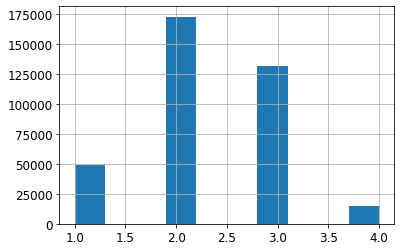

In [124]:
rentals["sqfeet_cat"].hist()

In [125]:
rentals["sqfeet_cat"].value_counts()

2    172569
3    131757
1     48641
4     14569
Name: sqfeet_cat, dtype: int64

In [126]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367536 entries, 0 to 384976
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   region                   367536 non-null  object  
 1   price                    367536 non-null  int64   
 2   type                     367536 non-null  object  
 3   sqfeet                   367536 non-null  int64   
 4   beds                     367536 non-null  int64   
 5   baths                    367536 non-null  float64 
 6   cats_allowed             367536 non-null  int64   
 7   dogs_allowed             367536 non-null  int64   
 8   smoking_allowed          367536 non-null  int64   
 9   wheelchair_access        367536 non-null  int64   
 10  electric_vehicle_charge  367536 non-null  int64   
 11  comes_furnished          367536 non-null  int64   
 12  laundry_options          367536 non-null  object  
 13  parking_options          367536 non-null  ob

In [127]:
rentals.isnull().sum()

region                     0
price                      0
type                       0
sqfeet                     0
beds                       0
baths                      0
cats_allowed               0
dogs_allowed               0
smoking_allowed            0
wheelchair_access          0
electric_vehicle_charge    0
comes_furnished            0
laundry_options            0
parking_options            0
lat                        0
long                       0
sqfeet_cat                 0
dtype: int64

In [128]:
rentals.describe()

,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,367536.000000,367536.000000,367536.000000,367536.000000,367536.000000,367536.00000,367536.000000,367536.000000,367536.000000,367536.000000,367536.000000,367536.000000
mean,1184.704992,987.871199,1.882822,1.475450,0.730377,0.71033,0.731066,0.081788,0.012739,0.046251,37.258887,-92.890074
std,548.647813,365.691684,0.870965,0.581068,0.443764,0.45361,0.443406,0.274042,0.112146,0.210029,5.549189,15.914636
min,150.000000,150.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,20.622000,-159.530000
25%,820.000000,750.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,33.470100,-101.318000
50%,1050.000000,945.000000,2.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,37.704800,-87.698600
75%,1400.000000,1143.000000,2.000000,2.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,41.160200,-81.162800
max,5000.000000,4000.000000,8.000000,7.500000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,64.993700,-68.207100


In [129]:
rentals.head(5)

,region,price,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,sqfeet_cat
0,reno / tahoe,1148,apartment,1078,3,2.0,1,1,0,0,0,0,w/d in unit,carport,39.5483,-119.796,3
1,reno / tahoe,1200,condo,1001,2,2.0,0,0,0,0,0,0,w/d hookups,carport,39.5026,-119.789,3
2,reno / tahoe,1813,apartment,1683,2,2.0,1,1,1,0,0,0,w/d in unit,attached garage,39.6269,-119.708,3
3,reno / tahoe,1095,apartment,708,1,1.0,1,1,1,0,0,0,w/d in unit,carport,39.4477,-119.771,2
4,reno / tahoe,289,apartment,250,0,1.0,1,1,1,1,0,1,laundry on site,unknown,39.5357,-119.805,1


In [130]:
rentals.iloc[212936]

region                          cincinnati
price                                  755
type                             apartment
sqfeet                                 670
beds                                     1
baths                                  1.0
cats_allowed                             1
dogs_allowed                             1
smoking_allowed                          1
wheelchair_access                        0
electric_vehicle_charge                  0
comes_furnished                          0
laundry_options            laundry on site
parking_options                    carport
lat                                39.1432
long                              -84.5217
sqfeet_cat                               2
Name: 224760, dtype: object

In [131]:
rentals.iloc[224760]

region                       oklahoma city
price                                  529
type                                 house
sqfeet                                1719
beds                                     3
baths                                  3.0
cats_allowed                             0
dogs_allowed                             0
smoking_allowed                          1
wheelchair_access                        0
electric_vehicle_charge                  0
comes_furnished                          0
laundry_options                w/d in unit
parking_options            attached garage
lat                                35.5042
long                              -97.4806
sqfeet_cat                               4
Name: 236845, dtype: object

At this point, we're going to go ahead and split up the data into test and train sets. 

We'll use the stratums we created with sq footage to evaluate the split. 

Scikit-learn provides a stratified shuffle split that we can use for these purposes, if the basic split method is unacceptable. 

In [152]:
from sklearn.model_selection import train_test_split

def sqfeet_categories_distributions(data):
    return data["sqfeet_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(rentals, test_size=0.2, random_state=42)

# from sklearn.model_selection import StratifiedShuffleSplit
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

compare_split = pd.DataFrame({
    "Overall Distribution": sqfeet_categories_distributions(rentals),
    "Random Split Distribution": sqfeet_categories_distributions(test_set),
}).sort_index()
compare_split["Rand. %error"] = 100 * compare_split["Random Split Distribution"] / compare_split["Overall Distribution"] - 100

In [153]:

test_set["sqfeet_cat"].value_counts() / len(test_set)

2    0.469731
3    0.358600
1    0.132489
4    0.039179
Name: sqfeet_cat, dtype: float64

In [154]:
rentals["sqfeet_cat"].value_counts() / len(rentals)

2    0.469530
3    0.358487
1    0.132343
4    0.039640
Name: sqfeet_cat, dtype: float64

In [155]:
compare_split

,Overall Distribution,Random Split Distribution,Rand. %error
1,0.132343,0.132489,0.109928
2,0.469530,0.469731,0.042952
3,0.358487,0.358600,0.031547
4,0.039640,0.039179,-1.161073


Remove the 'sqfeet_cat' column from both datasets

In [156]:
for set_ in (train_set, test_set):
    set_.drop("sqfeet_cat", axis=1, inplace=True)

c:\Users\eh172\Desktop\DS Research\Scripts\ML_pipelines\ml-env\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



So, now we will copy the train_set to use for the remainder of the prep process. We will need to do a similar process with the test_set, but 
we will not fit the test set, instead we will just transform.

We are going to name our copy as rentals_train_set.

Saving figure rental_prices_scatterplot


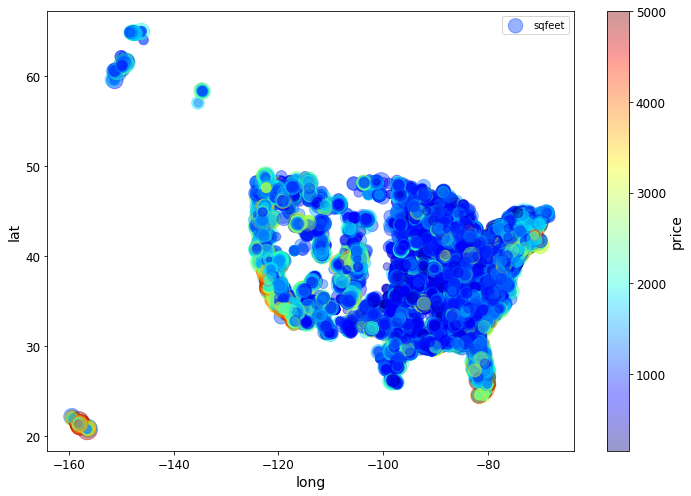

In [157]:
rentals_train_set = train_set.copy()# always good to use copy, just in case we need to undo at any point. Or, we can save to csv as before. 

rentals_train_set.plot(kind="scatter", x="long", y="lat", alpha=0.4,
             s=rentals_train_set["sqfeet"]/10, label="sqfeet", figsize=(10,7),
             c="price", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("rental_prices_scatterplot")

In [158]:
corr_matrix = rentals_train_set.corr()

In [159]:
corr_matrix["price"].sort_values(ascending=False)

price                      1.000000
sqfeet                     0.365444
baths                      0.275875
beds                       0.205646
electric_vehicle_charge    0.131344
wheelchair_access          0.074193
lat                        0.028082
comes_furnished            0.017331
dogs_allowed              -0.029472
cats_allowed              -0.038231
smoking_allowed           -0.161889
long                      -0.197833
Name: price, dtype: float64

In [160]:
correlation=rentals_train_set.corr()["price"].reset_index().sort_values("price",ascending=False)
fig=px.bar(correlation, x="index", y="price")
save_fig('correlation test set sorted')
fig.show()

Saving figure correlation test set sorted


<Figure size 432x288 with 0 Axes>

Saving figure scatter_matrix_plot_trainset


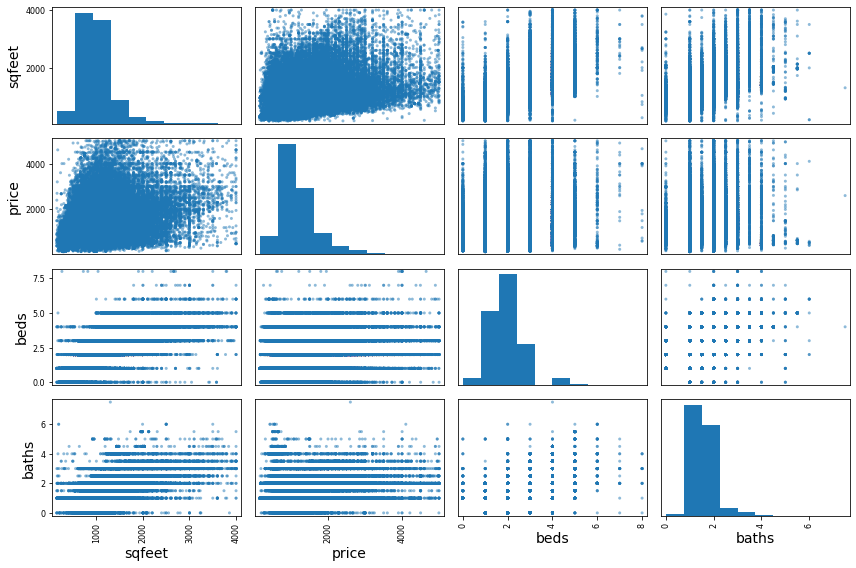

In [161]:
from pandas.plotting import scatter_matrix

attributes = ["sqfeet", "price", "beds",
              "baths"]
scatter_matrix(rentals_train_set[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot_trainset")

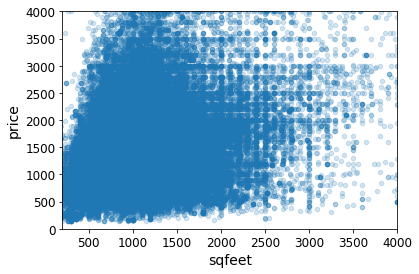

In [162]:
rentals_train_set.plot(kind="scatter", x="sqfeet", y="price",
             alpha=0.2)
plt.axis([200, 4000, 0, 4000])
plt.show()

We mentioned this earlier, but transforming and then scaling tail-heavy distributions to logarithm is one method to deal with these features if we have tail-heavy distros. 

<AxesSubplot:>

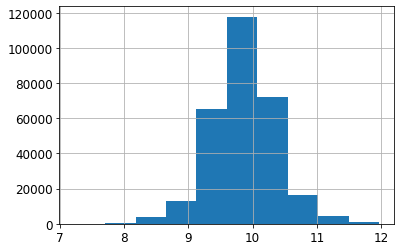

In [163]:
log_sqfeet = np.log2(rentals_train_set["sqfeet"])
log_sqfeet.hist()

We can also try some attribute experimentation combinations.

In [164]:
rentals_train_set.groupby(["region"])["price"].sum()

region
SF bay area               4994960
abilene                    573972
akron / canton            1037398
albany                    1246552
albuquerque               1459373
                           ...   
york                       516839
youngstown                 148734
yuba-sutter                181889
yuma                       135619
zanesville / cambridge     134255
Name: price, Length: 404, dtype: int64

In [165]:
rentals_train_set["region"].value_counts()

fredericksburg            2175
omaha / council bluffs    2174
salt lake city            2117
seattle-tacoma            2093
boulder                   2090
                          ... 
st louis                     8
southwest MS                 8
fort smith, AR               3
southwest TX                 2
kansas city                  1
Name: region, Length: 404, dtype: int64

In [166]:
rentals_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294028 entries, 166801 to 127335
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   294028 non-null  object 
 1   price                    294028 non-null  int64  
 2   type                     294028 non-null  object 
 3   sqfeet                   294028 non-null  int64  
 4   beds                     294028 non-null  int64  
 5   baths                    294028 non-null  float64
 6   cats_allowed             294028 non-null  int64  
 7   dogs_allowed             294028 non-null  int64  
 8   smoking_allowed          294028 non-null  int64  
 9   wheelchair_access        294028 non-null  int64  
 10  electric_vehicle_charge  294028 non-null  int64  
 11  comes_furnished          294028 non-null  int64  
 12  laundry_options          294028 non-null  object 
 13  parking_options          294028 non-null  object 
 14 

In [167]:
rentals_train_set.describe()

,price,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000
mean,1184.977805,988.177123,1.883708,1.475812,0.730328,0.710579,0.730886,0.082251,0.012802,0.046315,37.254949,-92.890224
std,549.781666,366.082434,0.871702,0.580916,0.443790,0.453495,0.443500,0.274747,0.112417,0.210167,5.547624,15.907924
min,150.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.622000,-159.519000
25%,820.000000,750.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.467600,-101.318000
50%,1050.000000,945.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.704800,-87.702300
75%,1400.000000,1144.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.158700,-81.163200
max,5000.000000,4000.000000,8.000000,7.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.993700,-68.207100


We're going to engineer features for the regions. We'll try adding a sq footage per bed and bath. Intuitively, these seem like important metrics, but we won't know until experimenting.  

We need to ensure we use this same approach with the test set as well. We have some zero beds and baths, so we'll come back to this when ready. 

Rooms per household is a more useful measure (potentially). As well as bedrooms per room total...this suggests that more bedrooms, i.e., lower bedrooms/room ratio, have higher expense. Also, rooms per household is intuitively more informative than total rooms in a district, and this is suggested in the correlation data. 

# Data Cleaning Options

Now, we'd like to prepare the data for Machine Learning algorithms. 

For this template, we'll the stratified dataset we generated, and split the data predictors and labels. 

First, we we want to create our training set and associated labels set. 

In [196]:
rentals_train_set = train_set.drop("price", axis=1) # drop labels for training set
rentals_train_set_labels = train_set["price"].copy()

Sampling the rows with incomplete data...using only the head of the data for experimentation.

In [274]:
rentals_train_set.describe()

,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000
mean,988.177123,1.942023,1.483195,0.730328,0.710579,0.730886,0.082251,0.012802,0.046315,37.254949,-92.890224
std,366.082434,0.808330,0.568330,0.443790,0.453495,0.443500,0.274747,0.112417,0.210167,5.547624,15.907924
min,150.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.622000,-159.519000
25%,750.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.467600,-101.318000
50%,945.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.704800,-87.702300
75%,1144.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.158700,-81.163200
max,4000.000000,8.000000,7.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.993700,-68.207100


Check some variables for skewness

In [285]:
atts_ex = ["sqfeet", "beds", "baths"]

num_feats = rentals_train_set.dtypes[atts_ex].index

skewness = rentals_train_set[num_feats].skew().sort_values(ascending=False)
skewdf = pd.DataFrame({"skew":skewness})
skewdf

,skew
sqfeet,1.846687
baths,0.970263
beds,0.784503


In [198]:
sample_incomplete_rows = rentals_train_set[rentals_train_set.isnull().any(axis=1)].head()
sample_incomplete_rows

,region,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long


In [199]:
sample_incomplete_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   region                   0 non-null      object 
 1   type                     0 non-null      object 
 2   sqfeet                   0 non-null      int64  
 3   beds                     0 non-null      int64  
 4   baths                    0 non-null      float64
 5   cats_allowed             0 non-null      int64  
 6   dogs_allowed             0 non-null      int64  
 7   smoking_allowed          0 non-null      int64  
 8   wheelchair_access        0 non-null      int64  
 9   electric_vehicle_charge  0 non-null      int64  
 10  comes_furnished          0 non-null      int64  
 11  laundry_options          0 non-null      object 
 12  parking_options          0 non-null      object 
 13  lat                      0 non-null      float64
 14  long                     0 non-null   

We can look at any inconsistent rows based on several feature measures...spelling errors, data types, irrelevant, etc.

Examples to remove based on regex, but this could be done in a variety of ways. 

We can use drop or replace methods for this purpose as we've done up to this point. 

In [200]:
rentals_train_set.head(5)

,region,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long
166801,gulfport / biloxi,apartment,1447,3,2.0,1,1,1,0,0,0,unknown,unknown,30.4135,-89.0213
167486,gulfport / biloxi,apartment,1392,2,2.0,0,0,1,0,0,0,unknown,unknown,30.3664,-88.5289
369232,fresno / madera,apartment,500,2,2.0,1,1,1,1,0,0,w/d in unit,carport,36.7976,-119.8080
39298,ft myers / SW florida,apartment,881,1,1.0,1,1,0,1,1,0,w/d in unit,off-street parking,26.5824,-81.8320
21543,denver,apartment,500,0,1.0,1,1,0,0,0,0,w/d in unit,off-street parking,39.7371,-105.0540


In [201]:
# example: remove rows that contain the target word
target = '[Uu]nown'

noisy_laundry = rentals_train_set[rentals_train_set['laundry_options'].str.contains(target, regex=True)]

# show rows that contains the word unknown in caps or lower
print(noisy_laundry['laundry_options'])

# get the index that contains the word noisy
index_to_drop = noisy_laundry['laundry_options'].index

# print(index_to_drop)
# rentals2.drop(index_to_drop, axis='index', inplace=True)

# replace values if desired...this example replaces any capitalized with lower case. Very simple form, could be automated with complex REGEX
# rentals2['laundry_options'].replace(['Unknown'],['unknown'], inplace=True)

Series([], Name: laundry_options, dtype: object)


Date/Time conversion, duplicates, and data types. 'col_name' dummy column for template.

In [338]:
#date/time convert
#rentals_train_set['col_name'] = pd.to_datetime(rentals_train_set['col_name'], format='%Y-%m-%d')
#rentals_train_set['col_name'].dtype.type

In [202]:
#duplicate row id and removal 
rentals_train_set.duplicated().any()

## if true
# rentals2.drop_duplicates()

## if you want to drop duplicates at specific column
# rentals2.drop('col_name', axis=1, inplace=True).drop_duplicates()

True

If we want to reduce memory usage of the dataframe, we can retype attributes. We'll do this on the rental datarame

In [203]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367536 entries, 0 to 384976
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   region                   367536 non-null  object  
 1   price                    367536 non-null  int64   
 2   type                     367536 non-null  object  
 3   sqfeet                   367536 non-null  int64   
 4   beds                     367536 non-null  int32   
 5   baths                    367536 non-null  float64 
 6   cats_allowed             367536 non-null  int64   
 7   dogs_allowed             367536 non-null  int64   
 8   smoking_allowed          367536 non-null  int64   
 9   wheelchair_access        367536 non-null  int64   
 10  electric_vehicle_charge  367536 non-null  int64   
 11  comes_furnished          367536 non-null  int64   
 12  laundry_options          367536 non-null  object  
 13  parking_options          367536 non-null  ob

In [204]:
#change to int32 and memory usage reduced ~ 1.4 MB
#we'll do this with rentals
rentals['beds'] = rentals['beds'].astype('int32')
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367536 entries, 0 to 384976
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   region                   367536 non-null  object  
 1   price                    367536 non-null  int64   
 2   type                     367536 non-null  object  
 3   sqfeet                   367536 non-null  int64   
 4   beds                     367536 non-null  int32   
 5   baths                    367536 non-null  float64 
 6   cats_allowed             367536 non-null  int64   
 7   dogs_allowed             367536 non-null  int64   
 8   smoking_allowed          367536 non-null  int64   
 9   wheelchair_access        367536 non-null  int64   
 10  electric_vehicle_charge  367536 non-null  int64   
 11  comes_furnished          367536 non-null  int64   
 12  laundry_options          367536 non-null  object  
 13  parking_options          367536 non-null  ob

We have no null values in our data, but we're going to replace the 0s in the beds and baths and then demo the imputer object on a test instance. 



In [205]:
(rentals_train_set['beds']==0).sum()

8573

In [206]:
(rentals_train_set['baths']==0).sum()

2171

In [207]:
rentals3 = rentals_train_set.copy()
(rentals3['beds']==0).sum()

8573

In [209]:
rentals3.describe()

,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
count,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000,294028.000000
mean,988.177123,1.883708,1.475812,0.730328,0.710579,0.730886,0.082251,0.012802,0.046315,37.254949,-92.890224
std,366.082434,0.871702,0.580916,0.443790,0.453495,0.443500,0.274747,0.112417,0.210167,5.547624,15.907924
min,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.622000,-159.519000
25%,750.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.467600,-101.318000
50%,945.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,37.704800,-87.702300
75%,1144.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,41.158700,-81.163200
max,4000.000000,8.000000,7.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.993700,-68.207100


In [210]:
rentals3['beds'] = rentals3['beds'].replace(0, np.nan)
rentals3['baths'] = rentals3['baths'].replace(0, np.nan)

And now we have some null values where we previously had 0s. We'll come back to rentals3 in a moment.

In [211]:
rentals3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294028 entries, 166801 to 127335
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   region                   294028 non-null  object 
 1   type                     294028 non-null  object 
 2   sqfeet                   294028 non-null  int64  
 3   beds                     285455 non-null  float64
 4   baths                    291857 non-null  float64
 5   cats_allowed             294028 non-null  int64  
 6   dogs_allowed             294028 non-null  int64  
 7   smoking_allowed          294028 non-null  int64  
 8   wheelchair_access        294028 non-null  int64  
 9   electric_vehicle_charge  294028 non-null  int64  
 10  comes_furnished          294028 non-null  int64  
 11  laundry_options          294028 non-null  object 
 12  parking_options          294028 non-null  object 
 13  lat                      294028 non-null  float64
 14 

# Data Cleaning Numerical

Some options for null values with numerical attributes:
1. We can drop the column if we don't think we need it (we've done this already).
2. We can drop the rows with null, or in this case, the original 0 values.
3. We can bfill/ffill (backward/forward fill).
4. We can impute values. 

For this template, imputing is selected, and the median strategy employed. 

We use an Estimator object (Imputer) for this framework. Scikit-Learn has a nice, consistent API and all objects share a simple interface.

Scikit-Learn API reference: https://scikit-learn.org/stable/modules/classes.html




In [212]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [213]:
#lets drop the categorical for imputation
cats = ['region', 'type', 'laundry_options', 'parking_options']

rentals3_num = rentals3.drop(cats, axis=1)
#rentals_train_set = rentals_train_set.select_dtypes(include=[np.number])

Now, remember, rentals3 has null values. 

In [214]:
rentals3_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294028 entries, 166801 to 127335
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sqfeet                   294028 non-null  int64  
 1   beds                     285455 non-null  float64
 2   baths                    291857 non-null  float64
 3   cats_allowed             294028 non-null  int64  
 4   dogs_allowed             294028 non-null  int64  
 5   smoking_allowed          294028 non-null  int64  
 6   wheelchair_access        294028 non-null  int64  
 7   electric_vehicle_charge  294028 non-null  int64  
 8   comes_furnished          294028 non-null  int64  
 9   lat                      294028 non-null  float64
 10  long                     294028 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 35.0 MB


In [215]:
imputer.fit(rentals3_num)
imputer.statistics_

array([945.    ,   2.    ,   1.    ,   1.    ,   1.    ,   1.    ,
         0.    ,   0.    ,   0.    ,  37.7048, -87.7023])

In [216]:
#imputer has merely computed median value for all attributes (numerical) and stored that result in the statistics_ instance variable. 
rentals3_num.median().values

array([945.    ,   2.    ,   1.    ,   1.    ,   1.    ,   1.    ,
         0.    ,   0.    ,   0.    ,  37.7048, -87.7023])

Technically, this instance is now a trained imputer. Thus, we can transform the training set by replacing the missing numerical values with the learned medians. 


In [217]:
X = imputer.transform(rentals3_num)
# X is numpy array with transformed features. Can put back into Pandas Dataframe if desired.
rentals3_num_tranz = pd.DataFrame(X, columns=rentals3_num.columns, index=rentals3.index)
rentals3_num_tranz.loc[sample_incomplete_rows.index.values]

,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long


In [218]:
rentals3_num_tranz

,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
166801,1447.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,30.4135,-89.0213
167486,1392.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,30.3664,-88.5289
369232,500.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,36.7976,-119.8080
39298,881.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,26.5824,-81.8320
21543,500.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,39.7371,-105.0540
...,...,...,...,...,...,...,...,...,...,...,...
271720,1242.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,43.5179,-96.7924
383220,676.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,33.8195,-116.5280
137747,1065.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,39.4242,-77.4597
153164,625.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,32.3081,-90.2021


In [219]:
(rentals3_num_tranz["beds"]==np.nan).sum()


0

In [221]:
rentals_train_set['beds'] = rentals_train_set['beds'].replace(0, 2)
rentals_train_set['baths'] = rentals_train_set['baths'].replace(0, 1)
rentals_train_set_num = rentals_train_set.drop(cats, axis=1)
(rentals_train_set_num['beds']<1).sum()

0

The beds and baths have been transformed in rentals3 df, and the NaN features converted to the medians, 2 and 1 respectively.

We did this manually with median values for rentals train set df.

We will use an imputer in our pipeline on the rentals train and test sets.

We also have numerical attributes that can be treated as categorical, or as binary numerical attributes. We are going to leave them as numerical, but treat them differently in the pipeline when it comes to scaling the numerical features. 

In [225]:
# we can treat the binary category variables in several different ways. We'll use a custom transformer for this problem, and keep them as numerical
binary_num = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished']

rentals_train_set_num_scaler = rentals_train_set_num.drop(binary_num, axis=1)

rentals_train_set_num_scaler.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 294028 entries, 166801 to 127335
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   sqfeet  294028 non-null  int64  
 1   beds    294028 non-null  int64  
 2   baths   294028 non-null  float64
 3   lat     294028 non-null  float64
 4   long    294028 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 21.5 MB


# Data Cleaning Categorical

Now we want to take care of the categorical attributes. Since most ML algorithms prefer to work with numbers, we'll convert the text to numbers. If we were doing some traditional data mining for pattern discovery (apriori or association rule mining) we would dig into this much deeper. That will be an addendum to this template. 

Options:
1. Transform in place to numerical value...many different approaches exist.
2. Create additional columns with dummy variables...pd.get_dummies

The method to use is subjective to the feature space exploration. For this template we'll look at several in place transforms as well as adding attributes with dummy variables. 

In [226]:
rentals_train_set_cat = rentals_train_set[cats]
rentals_train_set_cat.head(10)

,region,type,laundry_options,parking_options
166801,gulfport / biloxi,apartment,unknown,unknown
167486,gulfport / biloxi,apartment,unknown,unknown
369232,fresno / madera,apartment,w/d in unit,carport
39298,ft myers / SW florida,apartment,w/d in unit,off-street parking
21543,denver,apartment,w/d in unit,off-street parking
238176,stillwater,apartment,unknown,unknown
31142,"washington, DC",apartment,w/d in unit,off-street parking
299007,galveston,apartment,w/d in unit,unknown
280237,memphis,apartment,no laundry on site,carport
172723,springfield,house,unknown,unknown


We can use an ordinal or factorize encoder and map each category to a unique integer.

In [227]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
rentals_train_set_cat_encoded = ordinal_encoder.fit_transform(rentals_train_set_cat)
rentals_train_set_cat_encoded[:5]

array([[133.,   0.,   3.,   6.],
       [133.,   0.,   3.,   6.],
       [119.,   0.,   5.,   1.],
       [120.,   0.,   5.,   4.],
       [ 80.,   0.,   5.,   4.]])

In [228]:
ordinal_encoder.categories_

[array(['SF bay area', 'abilene', 'akron / canton', 'albany',
        'albuquerque', 'altoona-johnstown', 'amarillo', 'ames',
        'anchorage / mat-su', 'ann arbor', 'annapolis',
        'appleton-oshkosh-FDL', 'asheville', 'ashtabula', 'athens',
        'atlanta', 'auburn', 'augusta', 'austin', 'bakersfield',
        'baltimore', 'baton rouge', 'battle creek',
        'beaumont / port arthur', 'bellingham', 'bemidji', 'bend',
        'billings', 'binghamton', 'birmingham', 'bismarck', 'bloomington',
        'bloomington-normal', 'boise', 'boone', 'boston', 'boulder',
        'bowling green', 'bozeman', 'brainerd', 'brownsville', 'brunswick',
        'buffalo', 'butte', 'cape cod / islands', 'catskills',
        'cedar rapids', 'central NJ', 'central louisiana',
        'central michigan', 'champaign urbana', 'charleston', 'charlotte',
        'charlottesville', 'chattanooga', 'chautauqua', 'chicago', 'chico',
        'chillicothe', 'cincinnati', 'clarksville', 'cleveland',
        

Ordinal encoding works in some cases, but some ML algorithms will assume 4 is 'closer' to 3 than it is to 2, and that is not necessarily the case. 

To mitigate this concern, several other options include the use of an OneHotEncoder for this problem. This is not a good solution if we have a large number of categories (~region), because that will result in very large feature inputs and may slow down training at scale. 

Output of the onehotencoder is a SciPy sparse matrix. The SciPy sparse matrix only stores the location of the nonzero elements, saving memory. We can convert to dense array Numpy array with toarray() method.

In [229]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
rentals_train_set_cat_1hot = cat_encoder.fit_transform(rentals_train_set_cat)
rentals_train_set_cat_1hot

<294028x430 sparse matrix of type '<class 'numpy.float64'>'
	with 1176112 stored elements in Compressed Sparse Row format>

In [230]:
rentals_train_set_cat_1hot.toarray()

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

For attribute combining or customized cleanup tasks, we can add our own transformer that works within the Scikit-learn pipeline ecosystem. This will make things easier to vary hyperparameters for attribute exploration during learning evaluation. 

We will make a class that generates new attributes for our dataset. If we use the Sci-kit-Learn base classes, we can extend the methods of fit, transform, and fit_transform to utilize in a pipeline to make the model training easier.

Recall the attributes we want to generate:

rentals2["sqfeet_per_bed"] = rentals2["sqfeet"]/rentals2["beds"]

rentals2["sqfeet_per_bath"] = rentals2["sqfeet"]/rentals2["baths"]



In [231]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the column indices for the features we use to generate new attributes in the dataset with engineered features. 

sq_feet_in, beds_in, baths_in = 2, 3, 4

col_names = "sqfeet", "beds", "baths"
sq_feet_in, beds_in, baths_in = [rentals_train_set.columns.get_loc(c) for c in col_names] 

In [232]:
class EngAtts(BaseEstimator, TransformerMixin):
    def __init__(self, add_sqfeet_per_region=True): # no *args or **kargs
        self.add_sqfeet_per_region = add_sqfeet_per_region
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        sqfeet_per_bed = X[:, sq_feet_in] / X[:, beds_in]
        sqfeet_per_bath = X[:, sq_feet_in] / X[:, baths_in]
        if self.add_sqfeet_per_region:
            #sqfeet_per_region = do later
            return np.c_[X, sqfeet_per_bed, sqfeet_per_bath]
        else:
            return np.c_[X, sqfeet_per_bed, sqfeet_per_bath]

eng_atts = EngAtts(add_sqfeet_per_region=False)
rentals_train_set_extra_attribs = eng_atts.transform(rentals_train_set.values)
np.info(rentals_train_set_extra_attribs)

class:  ndarray
shape:  (294028, 17)
strides:  (8, 2352224)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x1fa6214a040
byteorder:  little
byteswap:  False
type: object


This returns a numpy array, good for our ML pipeline, but we can recover dataframe columns if desired. 

In [233]:
rentals_train_set_extra_attribs = pd.DataFrame(
    rentals_train_set_extra_attribs,
    columns=list(rentals_train_set.columns)+["sqfeet_per_bed", "sqfeet_per_bath"],
    index=rentals_train_set.index)
rentals_train_set_extra_attribs.head()

,region,type,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,laundry_options,parking_options,lat,long,sqfeet_per_bed,sqfeet_per_bath
166801,gulfport / biloxi,apartment,1447,3,2.0,1,1,1,0,0,0,unknown,unknown,30.4135,-89.0213,482.333333,723.5
167486,gulfport / biloxi,apartment,1392,2,2.0,0,0,1,0,0,0,unknown,unknown,30.3664,-88.5289,696.0,696.0
369232,fresno / madera,apartment,500,2,2.0,1,1,1,1,0,0,w/d in unit,carport,36.7976,-119.808,250.0,250.0
39298,ft myers / SW florida,apartment,881,1,1.0,1,1,0,1,1,0,w/d in unit,off-street parking,26.5824,-81.832,881.0,881.0
21543,denver,apartment,500,2,1.0,1,1,0,0,0,0,w/d in unit,off-street parking,39.7371,-105.054,250.0,500.0


In [234]:
(rentals_train_set_extra_attribs["sqfeet_per_bath"] < 1).sum()


0

# Transformer Pipeline

We start with numerical. This num_pipeline takes our numerical attributes (housing_num) and applies the imputer with median strategy to train on those features. 
We then use our custom attribute engineering class method to add numerical attributes to the dataset for learning purposes. 
We apply a feature scaling method for standardization. 

The categorial pipeline, cat_pipeline, takes our categorical attributes and applies one-hot encoding. 

Finally, we fit and transform. We want to make sure we fit only to the training set, and not fit the test data. 

To feed the mixed attribute type dataframe into the pipeline, we can create another custom class to select num/cat attributes. There are many ways to discover the type and shape the methods. 

We haven't discussed scaling the features, but we'll use the standard scaler. We don't think we have many outliers at this point, so we could try the min/max scaler, but to be safe we'll stick with the standard. 

The cats_allowed, dogs_allowed, smoking_allowed, wheelchair_access, electric_vehicle_charge, and comes_furnised features are numbers, but essentially binary categories. 

We'll create another list for these categories, and leave them as binary via a custom transformer instead of scaling these features.  


In [235]:
rentals_train_set_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294028 entries, 166801 to 127335
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sqfeet                   294028 non-null  int64  
 1   beds                     294028 non-null  int64  
 2   baths                    294028 non-null  float64
 3   cats_allowed             294028 non-null  int64  
 4   dogs_allowed             294028 non-null  int64  
 5   smoking_allowed          294028 non-null  int64  
 6   wheelchair_access        294028 non-null  int64  
 7   electric_vehicle_charge  294028 non-null  int64  
 8   comes_furnished          294028 non-null  int64  
 9   lat                      294028 non-null  float64
 10  long                     294028 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 35.0 MB


In [236]:
rentals_train_set_num

,sqfeet,beds,baths,cats_allowed,dogs_allowed,smoking_allowed,wheelchair_access,electric_vehicle_charge,comes_furnished,lat,long
166801,1447,3,2.0,1,1,1,0,0,0,30.4135,-89.0213
167486,1392,2,2.0,0,0,1,0,0,0,30.3664,-88.5289
369232,500,2,2.0,1,1,1,1,0,0,36.7976,-119.8080
39298,881,1,1.0,1,1,0,1,1,0,26.5824,-81.8320
21543,500,2,1.0,1,1,0,0,0,0,39.7371,-105.0540
...,...,...,...,...,...,...,...,...,...,...,...
271720,1242,2,2.0,0,0,1,0,0,0,43.5179,-96.7924
383220,676,1,1.0,1,1,1,0,0,0,33.8195,-116.5280
137747,1065,3,1.0,1,1,1,0,0,0,39.4242,-77.4597
153164,625,1,1.0,1,1,1,1,0,0,32.3081,-90.2021


In [237]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
        ('eng_atts', EngAtts())
    ])

rentals_train_set_num_tranz = num_pipeline.fit_transform(rentals_train_set_num_scaler)

We only want to scale the numerical values we identified earlier, and not the binary numerical values. This number pipeline has imputed missing values = np.nan, and added the engineered features to the dataset. 

In [238]:
rentals_train_set_num_tranz[0]

array([ 1.44700000e+03,  3.00000000e+00,  2.00000000e+00,  3.04135000e+01,
       -8.90213000e+01,  6.57602709e-02, -2.24665333e-02])

In [243]:
# binary_num is a list of binary number attributes
num_attribs = list(rentals_train_set_num)
cat_attribs = list(rentals_train_set_cat)
scale_attribs = list(rentals_train_set_num_scaler)
scale_attribs

['sqfeet', 'beds', 'baths', 'lat', 'long']

In [246]:
from sklearn.compose import ColumnTransformer

# this is just one way to use the full pipeline: 
# we call the num_pipeline on the numbers to impute missing and add the extra features (we use scale_attributes to avoid divide by zero with median imputer...
# we would use a more customized approach outside of this exercise, but we've already taken care of the imputation piece
# we call standard scaler on the scale attributes (without binary)
# we one hot encode the category attributes

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, scale_attribs),
        ("scale_nums1", StandardScaler(), scale_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

rentals_train_set_prepared = full_pipeline.fit_transform(rentals_train_set)

Earlier we looked at price and how we could transform that particular variable closer to a normal distribution. This is something we would want to do before scaling, otherwise we could scale to a still skewed distribution. There's a lot to discuss in this area, and we'll leave that for a dedicated discussion topic and iteration. 

One option in Scikit-Learn is the PowerTransformer instead of the standard scaler. The PowerTransformer uses logarithmic functions to to minimize skewness. 

We could import and try with: from sklearn.preprocessing import PowerTransformer

In [247]:
rentals_train_set_prepared

<294028x442 sparse matrix of type '<class 'numpy.float64'>'
	with 4704448 stored elements in Compressed Sparse Row format>

In [248]:
rentals_train_set_prepared.shape

(294028, 442)

# Training Phase

In [249]:
# We'll start with a Linear Regression Model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(rentals_train_set_prepared, rentals_train_set_labels)

LinearRegression()

In [250]:
# We'll take a few training instances and evaluate on these with the full preprocessing pipeline

sample_data = rentals_train_set.iloc[:5]
sample_labels = rentals_train_set_labels.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)

print("Predictions:", lin_reg.predict(sample_data_prepared))

Predictions: [1053.10947596 1038.53200561 1078.46725828 1259.93230898 1402.36450877]


In [251]:
# Compared to actual labels
print("Labels:", list(sample_labels))

Labels: [1045, 650, 715, 1460, 1225]


In [252]:
sample_data_prepared

<5x442 sparse matrix of type '<class 'numpy.float64'>'
	with 80 stored elements in Compressed Sparse Row format>

We'll check the RMSE on the sample data set. 

In [253]:
from sklearn.metrics import mean_squared_error

sample_predictions = lin_reg.predict(sample_data_prepared)
lin_rmse = mean_squared_error(sample_labels, sample_predictions, squared=False)#squared=True give MSE
lin_rmse

266.3143183493664

In [254]:
# now on the whole training set
from sklearn.metrics import mean_squared_error

rentals_train_set_predictions = lin_reg.predict(rentals_train_set_prepared)
lin_rmse = mean_squared_error(rentals_train_set_labels, rentals_train_set_predictions, squared=False)
lin_rmse

305.3119205086753

In [255]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(rentals_train_set_labels, rentals_train_set_predictions)
lin_mae

193.43746032291097

So, not a great score (not horrible though) given our dataset and objective to predict values. To remedy the underfitting (this is underfit, we are not making good predictions with this feature space), we have a lot of options to consider:
- we did not regularize, or constrain the model, so this isn't an option, but if we had we could reduce constraints
- add features...revisit our feature engineering processes and this is a good option in this case
- select more powerful model that is better suited to find more complex relationships

Let's select and train a different model that might work better on some of the nonlinear relationships. We'll use a DecisionTreeRegressor. This will take much more time to fit than the simple linear regressor.

In [256]:
from sklearn.tree import DecisionTreeRegressor

dec_tree_reg = DecisionTreeRegressor(random_state=42)
dec_tree_reg.fit(rentals_train_set_prepared, rentals_train_set_labels)

DecisionTreeRegressor(random_state=42)

In [257]:
rentals_train_set_predictions = dec_tree_reg.predict(rentals_train_set_prepared)
dec_tree_rmse = mean_squared_error(rentals_train_set_labels, rentals_train_set_predictions, squared=False)
dec_tree_rmse

36.73322294194079

Well...that's a much better fit...nearly perfect. So, we could have a case of everfitting. We can do some chunking of our training data, and get a better picture on our model validation. 

Later, we'll look at some hyperparameter tuning methods as well.

One way is we can use smaller training set(s), or folds, and a validation set. Scikit-Learn has a cross-validation feature that is perfect for this approach.
We'll use K-fold cross-validation which randomly splits the training set into folds, and then trains and evaluates k times, picking k-1 folds to train on, and evaluates against the remaining fold. 

We set k=5 for sake of time.

In [258]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dec_tree_reg, rentals_train_set_prepared, rentals_train_set_labels,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [259]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [248.59856853 247.10715622 251.83140545 252.79250813 246.04881851]
Mean: 249.2756913667759
Standard deviation: 2.62577314774724


Well...not quite as good as it looked earlier. Check the linear regression with the cross-val

In [260]:
lin_scores = cross_val_score(lin_reg, rentals_train_set_prepared, rentals_train_set_labels,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [308.19984943 306.06857138 305.18123149 303.39421564 306.23147987]
Mean: 305.8150695608996
Standard deviation: 1.5612251694192358


The linear regression performs about the same with the cross-val. 

Just for fun, we can try two other models: 

# Note

- The Random Forest Regressor takes a very long time to fit, and an extremely long time if you run the cross val with folds. I will skip that for this demo, but it's here if you want to try it, or let the cross val go over night. I recommend reducing folds if you decide to try it with this craigslist dataset.

- I ran the fit on the entire training set with 10 folds and got an rmse of 76.35

In [419]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(rentals_train_set_prepared, rentals_train_set_labels)

RandomForestRegressor(random_state=42)

In [420]:
rentals_train_set_predictions = forest_reg.predict(rentals_train_set_prepared)
forest_rmse = mean_squared_error(rentals_train_set_labels, rentals_train_set_predictions, squared=False)
forest_rmse

76.35147056023982

In [421]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, rentals_train_set_prepared, rentals_train_set_labels,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Note the cost of doing cross-validation, and using a model like RandomForestRegressor! 


In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(rentals_train_set_prepared, rentals_train_set_labels)
rrentals_train_set_predictions = svm_reg.predict(rentals_train_set_prepared)
svm_rmse = mean_squared_error(rentals_train_set_labels, rentals_train_set_predictions, squared=False)
svm_rmse

# Model Tuning

Let's say we want to explore some of the model hyperparameters and search for good combinations. We could do this manually, but this is very tedious and time consuming. Scikit-Learn has a GridSearchCV feature for this very process. 

Using our DecisionTree Regressor model, we can provide the hyperparameter/value combinations we would like to explore. 

In [262]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 4 (2x2) combinations of hyperparameters
    {'splitter': ['best', 'random'], 'min_samples_leaf': [1, 2]},
  ]

dec_tree_reg = DecisionTreeRegressor(random_state=42)

# train across 5 folds, that's a total of 20 rounds of training 
grid_search = GridSearchCV(dec_tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(rentals_train_set_prepared, rentals_train_set_labels)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'min_samples_leaf': [1, 2],
                          'splitter': ['best', 'random']}],
             return_train_score=True, scoring='neg_mean_squared_error')

We can speed the grid search with the class halvingGridSearchCV. Check out the literature for this class: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html

In [261]:
# from sklearn.experimental import enable_halving_search_cv 
# # now you can import normally from model_selection
# from sklearn.model_selection import HalvingGridSearchCV

In [263]:
grid_search.best_params_

{'min_samples_leaf': 2, 'splitter': 'random'}

What does this tell us? For starters, since there are very few values, we migth want to expand the search. Nevertheless, our best parameters to use are the random splitter with 2 set as the parameter for our minimum leaf samples. You can check the literature for the precises meanings of parameters. 

For better or for worse, we'll procedd with this model. 

In [264]:
grid_search.best_estimator_

DecisionTreeRegressor(min_samples_leaf=2, random_state=42, splitter='random')

In [265]:
cross_val_results = grid_search.cv_results_
for mean_score, params in zip(cross_val_results["mean_test_score"], cross_val_results["params"]):
    print(np.sqrt(-mean_score), params)

249.28952041954662 {'min_samples_leaf': 1, 'splitter': 'best'}
249.75705447697484 {'min_samples_leaf': 1, 'splitter': 'random'}
243.214050435601 {'min_samples_leaf': 2, 'splitter': 'best'}
241.06160968147114 {'min_samples_leaf': 2, 'splitter': 'random'}


The RMSE score is slightly lower than the score with default hyperparameters (1 and best)...so, we have successfully tuned our model:)

In [266]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,111.814507,1.807792,0.037799,0.001719,1,best,"{'min_samples_leaf': 1, 'splitter': 'best'}",-61801.248273,-61061.946654,-63419.056771,...,-62145.264991,1310.313851,3,-1294.818000,-1260.279188,-1288.760926,-1293.672351,-1253.899464,-1278.285986,17.542630
1,113.396243,3.555000,0.037813,0.003351,1,random,"{'min_samples_leaf': 1, 'splitter': 'random'}",-62478.147935,-61770.224401,-62255.480129,...,-62378.586261,345.375710,4,-1294.870928,-1260.878435,-1288.817570,-1294.220716,-1256.907564,-1279.139043,16.711143
2,82.342942,13.620633,0.035212,0.009583,2,best,"{'min_samples_leaf': 2, 'splitter': 'best'}",-59355.466448,-58613.189390,-59444.267706,...,-59153.074329,608.265126,2,-8150.637863,-8369.328890,-8157.302315,-8076.663594,-8506.545453,-8252.095623,160.339764
3,88.611056,10.473405,0.036631,0.005512,2,random,"{'min_samples_leaf': 2, 'splitter': 'random'}",-58722.721158,-58979.224212,-58082.645656,...,-58110.699662,865.242305,1,-13088.641993,-13239.536765,-12904.075218,-13247.742743,-12928.865864,-13081.772517,146.587611


# Alternative to GridSearch

If the hyperparameter search space is large, we can use RandomizedSearchCV to evaluate set of random combinations. In this way we can better control the compute budget via iterations. 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'max_leaf_nodes': randint(low=1, high=10),
        'max_features': randint(low=1, high=8),
    }

tree_reg = DecisionTreeRegressor(random_state=42)
rnd_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(rentals_train_set_prepared, rentals_train_set_labels)

In [ ]:
cross_val_results = rnd_search.cv_results_
for mean_score, params in zip(cross_val_results["mean_test_score"], cross_val_results["params"]):
    print(np.sqrt(-mean_score), params)

In [267]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.10745323e-02, 2.26513303e-02, 7.41280496e-03, 3.67141888e-02,
       1.90387821e-01, 3.16359763e-02, 2.75424455e-02, 5.27096837e-02,
       8.91315704e-03, 2.68978264e-02, 3.12234416e-02, 4.51939312e-02,
       2.97860964e-02, 8.61015922e-06, 4.39836183e-04, 6.42827767e-04,
       8.39021122e-04, 3.02540264e-04, 1.60258028e-04, 3.03634622e-05,
       2.55018782e-05, 1.92324080e-03, 2.46430855e-03, 5.36944634e-05,
       7.75781849e-04, 0.00000000e+00, 1.00567292e-04, 1.55503574e-03,
       4.55401455e-04, 2.76184482e-04, 4.20107413e-03, 6.67126743e-03,
       7.83930534e-04, 2.18846368e-04, 9.32899875e-05, 7.56003516e-05,
       1.43036726e-04, 0.00000000e+00, 2.08643556e-04, 4.48267001e-05,
       6.85404571e-04, 1.59159817e-04, 1.34271776e-04, 1.72115779e-04,
       9.33259422e-05, 4.79183325e-04, 1.44647028e-06, 1.16379028e-02,
       9.24407183e-03, 9.45672912e-05, 2.10072194e-04, 8.92105903e-07,
       1.15984911e-04, 1.44605813e-05, 3.33873697e-04, 2.90024279e-05,
      

In [268]:
extra_attribs = ["sqfeet_per_bed", "sqfeet_per_bath"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.1903878210294823, 'dogs_allowed'),
 (0.0610745322883232, 'sqfeet'),
 (0.052709683728176276, 'electric_vehicle_charge'),
 (0.04519393117379038, 'sqfeet_per_bed'),
 (0.036714188780610606, 'cats_allowed'),
 (0.03163597632153543, 'smoking_allowed'),
 (0.031223441646377914, 'long'),
 (0.029786096354503924, 'sqfeet_per_bath'),
 (0.027542445479776575, 'wheelchair_access'),
 (0.02689782641954783, 'lat'),
 (0.024954640975652198, 'san antonio'),
 (0.022651330285548856, 'beds'),
 (0.014496575163603306, 'long island'),
 (0.011637902800269037, 'boone'),
 (0.010112850700729634, 'waco'),
 (0.009491144036657349, 'zanesville / cambridge'),
 (0.009244071826680876, 'boston'),
 (0.008913157043325537, 'comes_furnished'),
 (0.008699138959884656, 'florence / muscle shoals'),
 (0.007984495121442321, 'south dakota'),
 (0.00798399913387058, 'new river valley'),
 (0.00792474569282991, 'monroe'),
 (0.007513437843737555, 'ocala'),
 (0.007412804958558115, 'baths'),
 (0.006823144833797504, 'scranton / wilkes-bar

# Evaluate on the test set with our best fit

Remember, to fill our 0s with 1s in beds and baths

In [269]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

X_test['beds'] = X_test['beds'].replace(0, 2)
X_test['baths'] = X_test['baths'].replace(0, 1)

X_test_prepared = full_pipeline.transform(X_test)#take a minute to think about what this does, and why it is a transform only, and not a fit_transform.
final_predictions = final_model.predict(X_test_prepared)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse 

230.58058474722824

Compute statistical confidence interval for our RMSE

# T-test for one sample

import scipy.stats as scs # t-test

Similar to Z Test. You should test your sample against an average value you already have and you want to check if your sample is statistically similar to that mean.

stat, p = scs.ttest_1samp(my_sample, popmean= your_mean_test_value)

print(f'Test statistics: {stat}')

print(f'p-Value: {p}')

In [270]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([225.7826317 , 235.28071605])

# Z Test One Sample compared to Population Mean
imports
from statsmodels.stats.weightstats import ztest

your_mean_test_value = the value you want to compare to. 
Example: A given restaurant has an average bill amount of $45 dollars among all of its locations and you want to compare if the mean expense on location A is equal to the business mean expense.
stat, p = ztest(my_sample, value=your_mean_test_value)
print(f'Test statistics: {stat}')
print(f'p-Value: {p}')

In [271]:
# z-scores instead of t-scores
m = len(squared_errors)
mean = squared_errors.mean()
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(225.78271154711572, 235.28063943125312)

In [315]:
import joblib

# save
joblib.dump(final_model, "final_model_iteration1.pkl") 

['final_model_iteration1.pkl']

In [324]:
!jupyter nbconvert  DS_Template_Housing_Data.ipynb --to html

[NbConvertApp] Converting notebook DS_Template_Housing_Data.ipynb to html
c:\users\eh172\desktop\ds research\scripts\ml_pipelines\ml-env\lib\site-packages\nbconvert\filters\widgetsdatatypefilter.py:69: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Writing 2429059 bytes to DS_Template_Housing_Data.html


# That's it for this iteration. Congratulations for making it to this point!